In [177]:
# autoimport 
%load_ext autoreload
%autoreload 2
from impute import estimate_lnorm, impute_from_sd, sample_from_lognormal, impute_from_subsistence
from impute import impute_and_calc_gini

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import pandas as pd
import tqdm

import multiprocessing as mp
from functools import partial

import scipy.stats as st
from scipy.stats import norm

# hide RuntimeWarning pandas
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
import numba

# @numba.jit(nopython=True)
def gini_coefficient(array):
    # array = np.array(array)
    n = array.shape[0]
    array_sorted = np.sort(array)
    index = np.arange(1, n+1)
    weighted_sum = (array_sorted * index).sum()
    
    gini = (2 * weighted_sum) / (n * array.sum()) - (n + 1) / n
    return gini

test_array = np.array((5 * [50]) + (10 * [100]) + (5 * [300]))
gini = gini_coefficient(test_array)


## Laad data

In [4]:
## CBS summary data
cbs_sum_fp = "/Users/werk/Documents/git_hipnl/uu_link_dev/analyse_bestanden/n_pers_per_adres_en_stats_cats_2023_06_28_v2.xlsx"
cbs_sum = pd.read_excel(cbs_sum_fp)

# voeg year_mun_id toe
cbs_sum['year_mun_id'] = cbs_sum['year'].astype(str) + "_" + cbs_sum['municipality_cbs'].str.replace(" ", "_")

cbs_sum.fillna(0, inplace=True)

cbs_sum.head()

,year,cbs_year,amco,municipality_kohier,municipality_cbs,pct_records_included,n_all_records,n_records,n_adresses,n_adresses_surname,...,cat4,cat_sum,cat1_pct,cat2_pct,cat3_pct,cat4_pct,omvang_hh,hh_per_huis,inw_per_huis,year_mun_id
0,1889,1889,10327,Doesburg,Doesburg,0.976909,563,550,406,512,...,5,406,0.724,0.062,0.202,0.012,4.056147,1.222485,5.274556,1889_Doesburg
1,1879,1879,10327,Doesburg,Doesburg,0.996289,539,537,417,528,...,3,417,0.784,0.014,0.194,0.007,4.079380,1.141436,5.007735,1879_Doesburg
2,1881,1879,10909,Harlingen,Harlingen,0.972973,37,36,35,36,...,0,35,0.971,0.000,0.029,0.000,4.168417,1.223925,5.295106,1881_Harlingen
3,1889,1889,10909,Harlingen,Harlingen,0.982618,978,961,802,918,...,4,802,0.827,0.041,0.127,0.005,4.184792,0.000000,0.000000,1889_Harlingen
4,1899,1899,10007,Vaals,Vaals,0.986627,1346,1328,662,1264,...,39,662,0.601,0.030,0.310,0.059,4.192908,1.923602,8.673943,1899_Vaals


CBS DATA LARGE

In [5]:
## load cbs_sum_large, for determining refpop for municipalities without adress data
cbs_sum_large = pd.read_parquet("cbs_stats_summarized_all_municipalities_2023_07_06.parquet", engine="pyarrow")

# merge with cbs_sum
cbs_sum_large = pd.merge(cbs_sum_large, cbs_sum[['cbs_year','amco', 'cat1_pct', 'cat2_pct', 'cat3_pct', 'cat4_pct']], left_on=['amco', 'year'], right_on=['amco', 'cbs_year'], how='left')

# calculate refpop column
# berekenen proporties
cbs_sum_large['refpop'] = cbs_sum_large.cat1 * cbs_sum_large.cat1_pct + cbs_sum_large.cat2 * cbs_sum_large.cat2_pct + cbs_sum_large.cat3 * cbs_sum_large.cat3_pct
# make cbs_sum['refpop_prop'] integer
cbs_sum_large['refpop'] = cbs_sum_large['refpop'].astype(int)

cbs_sum_large.head()

,year,amco,municipality,bewoonde_huizen,bewoonde_schepen,afzonderlijk_levenden,huisgezinnen,bevolking,beroepsbevolking,bewoonde_huizen_schepen,...,verwant_huizing,cat1,cat2,cat3,cbs_year,cat1_pct,cat2_pct,cat3_pct,cat4_pct,refpop
0,1849,10534,'s-Graveland,143.0,1.0,0.0,270.0,1247.0,<NA>,144.0,...,<NA>,270.0,540.0,270.0,NaN,NaN,NaN,NaN,NaN,0
1,1849,10052,'s-Gravendeel,312.0,0.0,0.0,530.0,2368.0,<NA>,312.0,...,<NA>,530.0,1060.0,530.0,NaN,NaN,NaN,NaN,NaN,0
2,1849,11434,'s-Gravenhage,10346.0,92.0,0.0,16011.0,72225.0,<NA>,10438.0,...,<NA>,16011.0,32022.0,16011.0,NaN,NaN,NaN,NaN,NaN,0
3,1849,10469,'s-Gravenmoer,113.0,0.0,0.0,175.0,825.0,<NA>,113.0,...,<NA>,175.0,350.0,175.0,NaN,NaN,NaN,NaN,NaN,0
4,1849,11059,'s-Gravenpolder,109.0,0.0,0.0,139.0,667.0,<NA>,109.0,...,<NA>,139.0,278.0,139.0,NaN,NaN,NaN,NaN,NaN,0


TAX DATA

In [6]:
tax_records_fp = "/Users/werk/Documents/git_hipnl/data/tax_records/tax_records_latest.parquet"
tax_records = pd.read_parquet(tax_records_fp, engine='pyarrow')
# add record_id, for easy reference. This is actually the order of the records in the parquet file
tax_records['tax_record_id'] = range(tax_records.shape[0])

tax_records.head()

,page_nr,place,volgnummer,wijk,house_nr_wijk,street,house_nr_street,title,firstnames,initials,...,marital_status,tax_raad2,deducations,income,month,notes_cleaning,cbs_year,cbscode,year_mun_id,tax_record_id
0,1,Eindhoven,1,<NA>,<NA>,Kerkstraat,9,Wed,<NA>,H.,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,0
1,1,Eindhoven,2,<NA>,<NA>,Vrijstraat,47,<NA>,<NA>,A.,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,1
2,1,Eindhoven,3,<NA>,<NA>,Vrijstraat,1,<NA>,Cath.,C.,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,2
3,1,Eindhoven,4,<NA>,<NA>,Markt,14,<NA>,<NA>,H.,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,3
4,1,Eindhoven,5,<NA>,<NA>,Prins Hendrikstraat,7a,<NA>,<NA>,J.,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,4


In [7]:
tax_schedule_fp = "/Users/werk/Documents/git_hipnl/data/tax_records/tax_schedule_latest.parquet"
tax_schedule = pd.read_parquet(tax_schedule_fp, engine='pyarrow')
tax_schedule.head()

,class_nr,min,max,verhoudingscijfer,tax,grondslag voor berekening van de aanslag,year,file_name,place,municipality,...,has_duplicate,file_id,sheet_name,pct,pct1,tax1,pct2,tax2,income_gross,income_taxable
0,1,300,400,0.125,<NA>,50.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,False,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,2,401,500,0.125,<NA>,62.5,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,False,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,3,501,600,0.125,<NA>,75.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,False,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,4,601,700,0.150,<NA>,105.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,False,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,5,701,800,0.150,<NA>,120.0,1909,Uden_1909_2.2.xlsx,Uden,Uden,...,False,13021329944,tax_schedule,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [8]:
# add year_mun_id to tax_schedule
file_id_year_mun_id_mapping = tax_records[['file_id', 'year_mun_id']].drop_duplicates().set_index('file_id').to_dict()['year_mun_id']
tax_schedule['year_mun_id'] = tax_schedule.file_id.map(file_id_year_mun_id_mapping)

In [223]:
tax_records.year_mun_id.unique().shape[0]

152

## Bewerk en filter data

#### Berwerk cbs

In [9]:
# refpop_cat1 = CBS_munics$huisgezinnen + CBS_munics$afzonderlijk_levenden
cbs_sum['cat1'] = cbs_sum['huisgezinnen'] + cbs_sum['afzonderlijk_levenden']

# refpop_cat2 = CBS_munics$afzonderlijk_levenden + (CBS_munics$huisgezinnen*2) + CBS_munics$overige_leden_huisgezin
cbs_sum['cat2'] = cbs_sum['afzonderlijk_levenden'] + (cbs_sum['huisgezinnen']*2) + cbs_sum['overige_leden_huisgezin']

# refpop_cat3 = CBS_munics$afzonderlijk_levenden + CBS_munics$huisgezinnen + CBS_munics$overige_leden_huisgezin
cbs_sum['cat3'] = cbs_sum['afzonderlijk_levenden'] + cbs_sum['huisgezinnen'] + cbs_sum['overige_leden_huisgezin'] + cbs_sum['niet_verwant_huizing']

# berekenen proporties
cbs_sum['refpop_prop'] = cbs_sum.cat1 * cbs_sum.cat1_pct + cbs_sum.cat2 * cbs_sum.cat2_pct + cbs_sum.cat3 * cbs_sum.cat3_pct
# make cbs_sum['refpop_prop'] integer
cbs_sum['refpop_prop'] = cbs_sum['refpop_prop'].astype(int)


# filte cbs_sum where no refpop is present
cbs_sum_ref = cbs_sum[cbs_sum.refpop_prop > 0]
cbs_sum_ref.head()

,year,cbs_year,amco,municipality_kohier,municipality_cbs,pct_records_included,n_all_records,n_records,n_adresses,n_adresses_surname,...,cat_sum,cat1_pct,cat2_pct,cat3_pct,cat4_pct,omvang_hh,hh_per_huis,inw_per_huis,year_mun_id,refpop_prop
0,1889,1889,10327,Doesburg,Doesburg,0.976909,563,550,406,512,...,406,0.724,0.062,0.202,0.012,4.056147,1.222485,5.274556,1889_Doesburg,1352
1,1879,1879,10327,Doesburg,Doesburg,0.996289,539,537,417,528,...,417,0.784,0.014,0.194,0.007,4.079380,1.141436,5.007735,1879_Doesburg,1255
2,1881,1879,10909,Harlingen,Harlingen,0.972973,37,36,35,36,...,35,0.971,0.000,0.029,0.000,4.168417,1.223925,5.295106,1881_Harlingen,2543
3,1889,1889,10909,Harlingen,Harlingen,0.982618,978,961,802,918,...,802,0.827,0.041,0.127,0.005,4.184792,0.000000,0.000000,1889_Harlingen,2817
4,1899,1899,10007,Vaals,Vaals,0.986627,1346,1328,662,1264,...,662,0.601,0.030,0.310,0.059,4.192908,1.923602,8.673943,1899_Vaals,1771


Filter cbs_sum_large -> keep year mun from tax records

In [10]:
##  filter cbs_sum_large; keep amco-year combiniations that are in tax_records
# create amco_year column
tax_records['amco_year'] = tax_records.amco.astype(str) + "_" + tax_records.cbs_year.astype(str)
cbs_sum_large['amco_year'] = cbs_sum_large.amco.astype(str) + "_" + cbs_sum_large.year.astype(str)

# Add year_mun_id to cbs_sum_large
# create mapping
acmo_year_mun_id_mapping = tax_records[['amco_year', 'year_mun_id']].drop_duplicates().set_index('amco_year').to_dict()['year_mun_id']
# map to cbs_large
cbs_sum_large['year_mun_id'] = cbs_sum_large.amco_year.map(acmo_year_mun_id_mapping)

# filter cbs_sum_large
cbs_sum_large_filt = cbs_sum_large.query("amco_year.isin(@tax_records.amco_year)").copy()

# inspect missing
missing_amco_year = [i for i in tax_records.amco_year.unique().tolist() if i not in cbs_sum_large_filt.amco_year.tolist()]
tax_records.query("amco_year.isin(@missing_amco_year)").year_mun_id.unique()

<StringArray>
['1889_Vaals', '1890_Swalmen', '1889_Schinnen', '1890_Meerlo',
 '1889_Beek_(L.)']
Length: 5, dtype: string

In [11]:
cbs_sum_large_filt

,year,amco,municipality,bewoonde_huizen,bewoonde_schepen,afzonderlijk_levenden,huisgezinnen,bevolking,beroepsbevolking,bewoonde_huizen_schepen,...,cat2,cat3,cbs_year,cat1_pct,cat2_pct,cat3_pct,cat4_pct,refpop,amco_year,year_mun_id
16,1849,11020,Aardenburg,282.0,0.0,0.0,369.0,1628.0,<NA>,282.0,...,738.0,369.0,NaN,NaN,NaN,NaN,NaN,0,11020_1849,1849_Aardenburg
1193,1859,11020,Aardenburg,308.0,0.0,54.0,337.0,1635.0,<NA>,308.0,...,728.0,524.0,1859.0,0.917,0.019,0.064,0.000,405,11020_1859,1859_Aardenburg
1265,1859,11374,Beek (L.),520.0,0.0,23.0,504.0,2572.0,<NA>,520.0,...,1031.0,775.0,NaN,NaN,NaN,NaN,NaN,0,11374_1859,1860_Beek_(L.)
1305,1859,11006,Bladel en Netersel,252.0,0.0,24.0,275.0,1342.0,<NA>,252.0,...,574.0,408.0,NaN,NaN,NaN,NaN,NaN,0,11006_1859,1859_Bladel_en_Netersel
1343,1859,10030,Brouwershaven,271.0,17.0,12.0,336.0,1648.0,<NA>,288.0,...,684.0,508.0,1859.0,0.698,0.000,0.287,0.016,388,10030_1859,1859_Brouwershaven
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8663,1920,11141,Uden,1228.0,0.0,0.0,<NA>,6888.0,<NA>,1228.0,...,0.0,0.0,1920.0,0.897,0.035,0.060,0.008,0,11141_1920,1920_Uden
8677,1920,10007,Vaals,852.0,0.0,0.0,<NA>,7831.0,<NA>,852.0,...,0.0,0.0,1920.0,0.303,0.187,0.240,0.270,0,10007_1920,1920_Vaals
8681,1920,11064,Varik,244.0,1.0,0.0,<NA>,1071.0,<NA>,245.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,11064_1920,1920_Varik
8694,1920,11414,"Vessem, Wintelre en Knegsel",230.0,0.0,0.0,<NA>,1186.0,<NA>,230.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0,11414_1920,"1920_Vessem,_Wintelre_en_Knegsel"


In [12]:
# # create copy of cbs_sum_large_filt. This will be used to impute refpop for municipalities without adress data
# cbs_large = cbs_sum_large_filt.copy()

# # add columnn in indicating the source of the refpop value
# cbs_large.loc[cbs_large.refpop > 0, 'refpop_source'] = 'cat_proportions'

# # use beroepsbevolking where refpop is missing
# brp_refpop_rows = cbs_large.eval("refpop.notna() & refpop_source.isna() & beroepsbevolking.notna()")
# cbs_large.loc[brp_refpop_rows, "refpop"] = cbs_large.loc[brp_refpop_rows, "beroepsbevolking"]
# cbs_large.loc[brp_refpop_rows, "refpop_source"] = "brp_value"

# # make refpop integer
# cbs_large.refpop = cbs_large.refpop.astype(int)

# cbs_large.head()

In [13]:
# Make long format from cbs_sum_large_filt
cbs_large_long_prep = cbs_sum_large_filt.copy()

# rename refpop column
cbs_large_long_prep.rename(columns={"refpop" : "refpop_catprop"}, inplace=True)
# replace 0 in refpop_catprop with nan
cbs_large_long_prep.loc[cbs_large_long_prep.refpop_catprop == 0, 'refpop_catprop'] = np.nan

# add refpop_brp column with beroepsbevolking
cbs_large_long_prep["refpop_brp"] = cbs_large_long_prep.beroepsbevolking
# replace 0 with nan
cbs_large_long_prep.loc[cbs_large_long_prep.refpop_brp == 0, 'refpop_brp'] = np.nan

# add refpop_hh column with cat1
cbs_large_long_prep["refpop_hh"] = cbs_large_long_prep.cat1
# replace 0 with nan
cbs_large_long_prep.loc[cbs_large_long_prep.refpop_hh == 0, 'refpop_hh'] = np.nan

# make long format with year_mun_id as index, and the refpop columns as values
cbs_large_long = cbs_large_long_prep.set_index('year_mun_id')[['refpop_catprop', 'refpop_brp', 'refpop_hh']].stack().reset_index().rename(columns={'level_1' : 'refpop_source', 0 : 'refpop'})

# make refpop integer
cbs_large_long.refpop = cbs_large_long.refpop.astype(int)

cbs_large_long

,year_mun_id,refpop_source,refpop
0,1849_Aardenburg,refpop_hh,369
1,1859_Aardenburg,refpop_catprop,405
2,1859_Aardenburg,refpop_hh,391
3,1860_Beek_(L.),refpop_hh,527
4,1859_Bladel_en_Netersel,refpop_hh,299
...,...,...,...
157,1909_Varik,refpop_brp,393
158,"1909_Vessem,_Wintelre_en_Knegsel",refpop_brp,736
159,1909_Weert,refpop_brp,4329
160,1917_Eindhoven,refpop_catprop,10947


## Imputaties

In [14]:
# tax_records_inc_ref_grp = tax_records_inc_ref.groupby("year_mun_id")

# grp_key = list(tax_records_inc_ref_grp.groups.keys())[0]

# grp_key = "1889_Harlingen"
# grp = tax_records_inc_ref_grp.get_group(grp_key)

# len(tax_records_inc_ref_grp)

#### Imputatie functie

##### Oud

In [15]:
def get_income_value(row, income_columns):
    """Get income value from row"""
    for col in income_columns:
        if pd.notnull(row[col]):
            if row[col] >= 0:
                return (row[col], col)
    return (None, None)

In [16]:
# tax_records_inc_ref_grp = tax_records_inc_ref.groupby("year_mun_id")
# print(f"{len(tax_records_inc_ref_grp)} municipalities with refpop\n")

def impute_income_values_df(tax_records_inc_ref, income_column="income_impute", refpop_column="refpop_prop", cbs_data=cbs_sum_ref, print_info=True):


    tax_records_inc_ref_grp = tax_records_inc_ref.groupby("year_mun_id")
    if print_info:
        print(f"{len(tax_records_inc_ref_grp)} municipalities with refpop\n")

    imputed_results = []

    for grp_key, grp in tax_records_inc_ref_grp:

        # get stats for this municipality
        stats_muni = cbs_data.query("year_mun_id == @grp_key")
        # get number of refpop
        n_refpop = stats_muni[refpop_column].values[0]
        # get number of missing
        n_missing = n_refpop - len(grp)

        # get values to impute
        y_to_impute = grp.query(f"{income_column} > 0")[income_column]
        # get minimum income
        min_inc = y_to_impute.min()

        if print_info:
            print(f"{grp_key}\n{min_inc = }, {n_refpop = }, {n_missing = }, n_belast = {len(grp)}, huishoudens: {stats_muni.huishoudens.values[0]}\n")

        # impute values. returns a numpy array with original values and imputed values

        imputed = sample_from_lognormal(y_to_impute, n_missing)

        # only missing values
        missing_imputed = imputed[n_missing:]
        missing_df = pd.Series(missing_imputed).to_frame().rename(columns={0: income_column})
        # add year_mun_id
        missing_df['year_mun_id'] = grp_key
        # add surname column, to be able to identify imputed values
        missing_df['surname'] = "IMPUTED"
        # add column indicating from which column the imputation was done
        impute_from = grp.income_impute_from.unique()[0]
        missing_df['income_impute_from'] = f"{impute_from}_imputed"

        imputed_results.append(missing_df)

    # merge
    imputed_df = pd.concat(imputed_results)


    # merge with tax_records_inc_ref
    imputed_df_tax_records = pd.concat([tax_records_inc_ref, imputed_df], ignore_index=True)

    # sort, so that all year_mun_id are together
    imputed_df_tax_records.sort_values(by=['year_mun_id', income_column], ascending=False, inplace=True)

    return imputed_df_tax_records


# imputed_df = impute_income_values_df(tax_records_inc_ref)

In [17]:
def quick_gini_simulation(tax_records_inc_ref, year_mun_id=None, income_column="income_impute", refpop_column="refpop_prop", cbs_data=cbs_sum_ref, rounds=100):

    if year_mun_id is None:
        year_mun_id = tax_records_inc_ref.year_mun_id.unique()[0]

    grp = tax_records_inc_ref.query(f"year_mun_id == '{year_mun_id}'")
    # get stats for this municipality
    stats_muni = cbs_data.query("year_mun_id == @year_mun_id")
    # get number of refpop
    n_refpop = stats_muni[refpop_column].values[0]
    # get number of missing
    n_missing = n_refpop - len(grp)

    # get values to impute
    y_to_impute = grp.query(f"{income_column} > 0")[income_column]
    # get minimum income
    min_inc = y_to_impute.min()

    ginis = []
    for i in tqdm.tqdm(range(rounds)):
        imputed = sample_from_lognormal(y_to_impute, n_missing)
        gini = gini_coefficient(imputed)
        ginis.append(gini)

    ginis = pd.Series(ginis)
    return ginis

In [18]:
def impute_income_values_year_mun(df, income_column="income_impute", refpop_column="refpop_prop", cbs_data=cbs_sum_ref):
    """Impute income values for a single column for a single year_mun_id"""

    year_mun_id = df.year_mun_id.unique()[0]
    # get stats for this municipality
    stats_muni = cbs_data.query("year_mun_id == @year_mun_id")
    try:
        # get number of refpop
        n_refpop = stats_muni[refpop_column].values[0]
    except:
        print(f"no refpop for {year_mun_id}. {stats_muni.shape[0]} rows in cbs_data filter. Refpop value: {stats_muni[refpop_column].values}. {refpop_column = }")
        raise ValueError
        
    # get number of missing
    n_missing = n_refpop - df.shape[0]
    print(f"{n_missing = }, {n_refpop = }, n_belast = {df.shape[0]}, huishoudens: {stats_muni.huishoudens.values[0]}\n")
    
    # get values to impute
    y_to_impute = df.query(f"{income_column} > 0")[income_column]

    # check if there are multiple distinct values in y_to_impute (otherwise there is no distribution)
    if len(y_to_impute.unique()) == 1:
        print(f"Only one distinct value in {income_column} for {year_mun_id}. Skipping imputation.")
        return pd.DataFrame()

    # impute values. returns a numpy array with original values and imputed values
    imputed = sample_from_lognormal(y_to_impute, n_missing)

    # only missing values
    imputed_df = pd.Series(imputed).to_frame().rename(columns={0: f"{income_column}_imputed"})
    # add year_mun_id
    imputed_df['year_mun_id'] = year_mun_id

    # Add column indicating from which column the imputation was done
    imputed_df[f"is_{income_column}_imputed"] = False
    imputed_df.loc[len(y_to_impute) :, f"is_{income_column}_imputed"] = True

    # add original index
    imputed_df['original_index'] = np.nan
    imputed_df.loc[: df.shape[0]-1, 'original_index'] = df.index.tolist()
    
    return imputed_df



def impute_all_income_columns(df, columns_to_impute, refpop_column="refpop_prop", cbs_data=cbs_sum_ref):
    """
    Impute all columns in columns_to_impute for a given year_mun_id (df)
    """

    missing_dfs = []
    # impute all columns that are more than 50% filled
    for col in columns_to_impute:
        print(col)
        missing_df = impute_income_values_year_mun(df, income_column=col, refpop_column=refpop_column, cbs_data=cbs_data)
        if missing_df.shape[0] > 0:
            missing_dfs.append(missing_df)

    if len(missing_dfs) == 0:
        return pd.DataFrame()
        
    # join all missing_dfs on year_mun_id and surname
    missing_df = pd.concat(missing_dfs, ignore_index=False, axis=1, join="inner")

    # drop year_mun_id columns (because they are all the same)
    missing_df.drop(columns="year_mun_id", inplace=True)

    # add new year_mun_id column, for joining with tax_records_inc_ref
    missing_df['year_mun_id'] = df.year_mun_id.unique()[0]
    
    # column that indicates the original index value
    if len(columns_to_impute) > 1:
        missing_df['original_index_value'] = missing_df['original_index'].apply(lambda x : list(set(x))[0], axis=1)
    else:
        missing_df['original_index_value'] = missing_df['original_index']
    # add column indicating this row is an complete imputation
    missing_df['imputed_record'] = missing_df['original_index_value'].isna()

    # drop original_index
    missing_df.drop(columns='original_index', inplace=True)

    return missing_df

##### Nieuw (obv tax)

In [190]:
def get_class_table(df, tax_schedule, income_class_column="income_class"):
    # count number of values in each class
    class_table = df[income_class_column].value_counts().to_frame()
    # add min and max values for each class
    class_table[['min', 'max']] = tax_schedule.groupby("class_nr")[['min', 'max']].mean()
    return class_table


def find_class(df, tax_schedule, tax_value_column="tax"):

    tax_schedule = tax_schedule.sort_values(by='min_tax')

    bins = pd.IntervalIndex.from_tuples(tax_schedule[['min_tax', 'tax']].apply(tuple, axis=1), closed='both')
    labels = tax_schedule['class_nr'].tolist()

    # Cut the data. You will have to cast it to float before using it.
    df['class_nr'] = pd.cut(df[tax_value_column], bins=bins).cat.codes
    df['class_nr'] = df['class_nr'].apply(lambda x: labels[x] if x != -1 else np.nan)

    return df['class_nr']


def simulate_and_impute_incomes(grp, year_mun_id, n_missing, tax_schedule, n_iterations=1000, n_pools=6):

    # assign class nrs
    grp['class_nr'] = find_class(grp, tax_schedule, "tax_value")
    # get class table
    class_table = get_class_table(grp, tax_schedule, 'class_nr')
    # sort class_table by index (class_nr)
    class_table.sort_index(inplace=True)

    # Here, `args` represents variables you need for `impute_and_calc_gini()`
    # like `n_missing` and `class_table`, you need to replace it with your actual variables.
    args = [(i, n_missing, class_table) for i in range(n_iterations)]
    # Create a pool of workers, and map `impute_and_calc_gini()` to the pool
    with mp.Pool(n_pools) as pool:
        results = pool.starmap(impute_and_calc_gini, args)
    # `results` is a list of tuples, where each tuple is the result of `impute_and_calc_gini()`
    ginis, simulated_incomes_list, imputed_results = zip(*results)

    # conver ginist to series
    ginis = pd.Series(ginis)

    # find index of gini closest to the mean
    idx = (np.abs(ginis - ginis.mean())).idxmin()
    # get simulated incomes with idx
    simulated_incomes_best = simulated_incomes_list[idx]

    # sort grp by class_nr
    grp.sort_values(by='class_nr', inplace=True)

    # add simulated incomes (where class_nr is not nan)
    grp.loc[grp.class_nr.notna(), ['income_value']] = simulated_incomes_best
    # set simulated_income to income_value where class_nr is nan
    grp.loc[grp.class_nr.isna(), ['income_value']] = None

    # sort grp again by index
    grp.sort_index(inplace=True)

    # get only imputed values
    imputed_values = imputed_results[idx][grp.shape[0]:]

    # create gini summary
    gini_summary = ginis.describe()
    gini_summary.name = year_mun_id

    return (grp, imputed_values, gini_summary)

In [189]:
class_table_order = class_table.index.tolist()


['2',
 '3',
 '1',
 '4',
 '5',
 '8',
 '10',
 '7',
 '9',
 '6',
 '11',
 '12',
 '14',
 '13',
 '16',
 '15',
 '26',
 '20',
 '21',
 '24',
 '17',
 '19',
 '22',
 '23',
 '34']

### Experimenten

#### impute income

##### Prepare tax_records, make long format

In [20]:
# Make long format from tax_records income columns

# list with all income columns
income_columns = ['income_gross', 'income', 'income_unspecified', 'income_raad', 'income_taxable']
# list with all tax columns
tax_columns = ['tax', 'tax2', 'tax_raad', 'tax_raad2', 'tax2_raad']

# make long format
index_columns = ["year_mun_id", "cbs_year", 'tax_record_id']
tax_records_long_income = tax_records[index_columns + income_columns + tax_columns].set_index(index_columns).stack().reset_index()

# rename columns
tax_records_long_income.rename(columns={'level_3': 'income_type', 0: 'income_value'}, inplace=True)

# make income_value numeric
tax_records_long_income.income_value = pd.to_numeric(tax_records_long_income.income_value, errors='coerce')

# add column indicating value is imputed
tax_records_long_income['is_imputed'] = False

# add column indicating income is from tax
tax_records_long_income['income_from_tax'] = False
tax_records_long_income.loc[tax_records_long_income.income_type.isin(tax_columns), 'income_from_tax'] = True

# add column indicating original tax value
tax_records_long_income['tax_value'] = np.nan
tax_records_long_income.loc[tax_records_long_income.income_from_tax, 'tax_value'] = tax_records_long_income.loc[tax_records_long_income.income_from_tax, 'income_value']


# filter out year_mun_id without refpop in cbs_large_long
tax_records_long_income = tax_records_long_income.query("year_mun_id.isin(@cbs_large_long.year_mun_id)").copy()

# add column indicating the refpop source. First set tot 'naive'
tax_records_long_income['refpop_source'] = 'naive'

tax_records_long_income

,year_mun_id,cbs_year,tax_record_id,income_type,income_value,is_imputed,income_from_tax,tax_value,refpop_source
0,1917_Eindhoven,1920,0,income_gross,1000.000,False,False,NaN,naive
1,1917_Eindhoven,1920,0,income_raad,600.000,False,False,NaN,naive
2,1917_Eindhoven,1920,0,income_taxable,600.000,False,False,NaN,naive
3,1917_Eindhoven,1920,0,tax,9.600,False,True,9.600,naive
4,1917_Eindhoven,1920,0,tax2,1.200,False,True,1.200,naive
...,...,...,...,...,...,...,...,...,...
165417,1909_Brummen,1909,70414,tax,11.865,False,True,11.865,naive
165418,1909_Brummen,1909,70415,income,50.000,False,False,NaN,naive
165419,1909_Brummen,1909,70415,tax,0.750,False,True,0.750,naive
165420,1909_Brummen,1909,70416,income,16000.000,False,False,NaN,naive


In [30]:
# Calculate the number of rows per year_mun_id
rows_per_year_mun_id = tax_records.groupby("year_mun_id").size()
# calculate percentage filled
percentage_filled = tax_records_long_income.groupby(["year_mun_id", "income_type"]).apply(lambda x : x.shape[0] / rows_per_year_mun_id[x.year_mun_id.unique()[0]])
percentage_filled.head()

year_mun_id             income_type
1849_Aardenburg         tax            1.0
1858_Eindhoven          tax            1.0
1858_Made_en_Drimmelen  tax            1.0
                        tax_raad       1.0
1858_Riethoven          tax            1.0
dtype: float64

##### Prepare tax_schedule, make long format and filter

In [23]:
# get tax schedule for each file in tax_records_with_schedule
tax_schedule_filtered = tax_schedule.query("year_mun_id.isin(@tax_records_long_income.year_mun_id.unique())")

# keep tax_schedule_filtered for each year_mun_id where at least three values in the max column are present
tax_schedule_filtered = tax_schedule_filtered.groupby("year_mun_id").filter(lambda grp: grp['max'].notna().sum() >= 3).copy()

# drop empty columns
tax_schedule_filtered.dropna(axis=1, how='all', inplace=True)
# Make tax column numeric
tax_schedule_filtered.tax = tax_schedule_filtered.tax.astype(float)

tax_schedule_filtered.year_mun_id.unique()

array(['1909_Uden', '1889_Brouwershaven', '1899_Nijmegen',
       '1889_Riethoven', '1911_Aardenburg', '1899_Riethoven',
       '1889_Maarheeze', '1899_Maarheeze', '1879_Maarheeze',
       '1899_Leende', '1889_Leende', '1909_Swalmen', '1909_Schinnen',
       '1909_Berg_en_Terblijt', '1899_Berg_en_Terblijt', '1889_Nijmegen',
       '1909_Beesd', '1899_Beesd', '1859_Harlingen', '1870_Harlingen',
       '1909_Brummen'], dtype=object)

In [24]:
# fix "year_mun_id == '1911_Aardenburg' & tax == 51.680"
tax_schedule_filtered.loc[(tax_schedule_filtered.year_mun_id == '1911_Aardenburg') & (tax_schedule_filtered.tax == 51.680), 'tax'] = 5.680


## FIX BROUWERSHAVEN TAX SCHEDULE ##
# replace max value for brouwershaven at class_nr 14 with 2700
filt = tax_schedule_filtered.eval("year_mun_id == '1889_Brouwershaven' & class_nr == '14'")
tax_schedule_filtered.loc[filt, "max"] = 2700

In [25]:
# remove rows without a tax value
tax_schedule_filtered = tax_schedule_filtered.query("tax.notna()")

# sort by year_mun_id and max
tax_schedule_filtered.sort_values(by=['year_mun_id', 'max'], inplace=True)

# add min_tax column, which is the minimum tax for each next class. The first class has no min_tax, so it is filled with 0. This asumes that
# a tax amount is more likely to be lower than the prescribed value for a certain income class than higher, due to deductions.
tax_schedule_filtered['min_tax'] = tax_schedule_filtered.groupby("year_mun_id")['tax'].shift(1) + 0.01

# fill first min_tax with 0
tax_schedule_filtered['min_tax'].fillna(0.0, inplace=True)

# add class number if missing for a group. These should just be row numbers for each year_mun_id
tax_schedule_filtered['class'] = tax_schedule_filtered.groupby("year_mun_id").cumcount() + 1
# fill class_nr with 'class' column
tax_schedule_filtered['class_nr'].fillna(tax_schedule_filtered['class'].astype(str), inplace=True)

# # where the min column is empty, fill with the previous max value + 1
# tax_schedule_filtered['min'].fillna(tax_schedule_filtered.groupby("year_mun_id")['max'].shift(1) + 1, inplace=True)
# # fill first min with 0
# tax_schedule_filtered['min'].fillna(0, inplace=True)

In [26]:
def determine_min_class_value(grp):

    # if 'min' column is not empty, return the min column
    if grp['min'].notna().sum() > 0:
        return grp
    # assign initial min value, as the previous max value minus the difference between the first two max values
    grp['min'] = grp['max'].shift(1)
    # calculate difference between the max of the first two classes
    first_max_step = grp['max'].iloc[1] - grp['max'].iloc[0]
    # calculate first min value, by subtracting the first max step from the max value of the first class
    first_min_value = grp['max'].iloc[0] - first_max_step

    # fill first min value
    grp.loc[grp['class_nr'] == grp.class_nr.iloc[0], 'min'] = first_min_value if first_min_value > 0 else 0

    # add 1 to min value, so that the min value is always lower than the previous max value
    grp['min'] += 1

    return grp

# determine min values for each year_mun_id (only for groups with no min values)
tax_schedule_filtered = tax_schedule_filtered.groupby("year_mun_id").apply(determine_min_class_value) #.fillna(tax_schedule_filtered.groupby("year_mun_id").apply(determine_min_class_value), inplace=True)
tax_schedule_filtered.reset_index(drop=True, inplace=True)

# get alternative min values for each year_mun_id (for groups with min values, but with only one min value missing (usually the first min value)))
min_values_fillna = tax_schedule_filtered.groupby("year_mun_id").apply(lambda grp: grp['max'].diff(periods=-1) + grp['max']).reset_index()['max'] + 1

# fillna for min values
tax_schedule_filtered['min'].fillna(min_values_fillna, inplace=True)

tax_schedule_filtered.head()

,class_nr,min,max,verhoudingscijfer,tax,grondslag voor berekening van de aanslag,year,file_name,place,municipality,amco,province,has_duplicate,file_id,sheet_name,pct,year_mun_id,min_tax,class
0,1,500,700,<NA>,6.0,<NA>,1859,Harlingen 1859 form 2.xlsx,Harlingen,Harlingen,10909,Friesland,False,12195497294,tax_schedule,<NA>,1859_Harlingen,0.00,1
1,2,701,1000,<NA>,9.0,<NA>,1859,Harlingen 1859 form 2.xlsx,Harlingen,Harlingen,10909,Friesland,False,12195497294,tax_schedule,<NA>,1859_Harlingen,6.01,2
2,3,1001,1400,<NA>,13.0,<NA>,1859,Harlingen 1859 form 2.xlsx,Harlingen,Harlingen,10909,Friesland,False,12195497294,tax_schedule,<NA>,1859_Harlingen,9.01,3
3,4,1401,1900,<NA>,20.0,<NA>,1859,Harlingen 1859 form 2.xlsx,Harlingen,Harlingen,10909,Friesland,False,12195497294,tax_schedule,<NA>,1859_Harlingen,13.01,4
4,5,1901,2500,<NA>,30.0,<NA>,1859,Harlingen 1859 form 2.xlsx,Harlingen,Harlingen,10909,Friesland,False,12195497294,tax_schedule,<NA>,1859_Harlingen,20.01,5


##### Filter `tax_schedule_filtered` to only include real income values, or tax values which can be translated with the tax schedule > `year_mun_ids_with_tax_schedule`

In [165]:
(22.89 - 18.65)/ 2 + 18.65

20.77

In [27]:
# filter tax_records_long_income

# get year_mun_ids with a valid tax schedule
year_mun_ids_with_tax_schedule = tax_schedule_filtered.year_mun_id.unique().tolist()

# filter tax_records_long_income to only include year_mun_ids that are in tax_schedule_filtered, or where income_from_tax is False
tax_records_long_income_with_schedule = tax_records_long_income.query("(income_from_tax == False) | (income_from_tax == True & year_mun_id.isin(@year_mun_ids_with_tax_schedule))").copy()

##### Do impuations

In [28]:
# tax_records_long_income_grp = tax_records_long_income_with_schedule.groupby(["year_mun_id", "income_type"])

# grp_key = list(tax_records_long_income_grp.groups.keys())[0]
# grp = tax_records_long_income_grp.get_group(grp_key)
# grp

In [249]:
# group tax_records_long_income_with_schedule
tax_records_long_income_grp = tax_records_long_income_with_schedule.groupby(["year_mun_id", "income_type"])
# group cbs_large_long by year_mun_id
cbs_large_long_grp = cbs_large_long.groupby('year_mun_id')
# group tax_schedule_filtered
tax_schedule_filtered_grp = tax_schedule_filtered.groupby('year_mun_id')


imputed_dfs_all = []
gini_summaries = []
skiped_year_mun_ids = []

done_year_mun_ids = [(i.year_mun_id.iloc[0], i.income_type.iloc[0]) for i in imputed_dfs_all]

# iterate over tax_records_long_income_grp groups
for (year_mun_id, income_type), grp in tax_records_long_income_grp:

    if (year_mun_id, income_type) in done_year_mun_ids:
        continue
    # for each income_type, impute values for each refpop source/row
    print(year_mun_id, income_type)

    # check if percentage_filled is > 0.5
    perc_filled = percentage_filled[(year_mun_id, income_type)]
    if perc_filled < 0.5:
        msg = f"> Percentage filled for {year_mun_id}, {income_type} is {perc_filled:.3f}. Skipping imputation."
        print(msg)
        skiped_year_mun_ids.append((year_mun_id, income_type, msg))
        continue

    # get refpop rows
    refpops = cbs_large_long_grp.get_group(year_mun_id)

    # get cbs_year
    cbs_year = grp.cbs_year.iloc[0]
    
    # list to store imputed values dfs. First add the original grp, so in the analysis it's easy to just view/analyse the 
    # originaly values, and/or different imputation scenario's
    imputed_dfs = [grp, ]

    # set variable indicating income_from_tax
    income_from_tax = grp.income_from_tax.iloc[0]
    
    # iterate over refpops rows
    for _, refpop_row in refpops.iterrows():

        # income_values to impute (only positive values)
        income_values = grp.income_value[grp.income_value > 0]

        # if income_values has one unique value, skip imputation
        if len(income_values.unique()) == 1:
            msg = f"> Only one unique value for {year_mun_id}, {income_type}. Skipping imputation."
            print(msg)
            skiped_year_mun_ids.append((year_mun_id, income_type, msg))
            continue
        
        # calculate n_missing
        n_missing = refpop_row.refpop - len(grp)

        # imputations for income_from_tax
        if income_from_tax:
            # get tax schedule for current year_mun_id
            grp_tax_schedule = tax_schedule_filtered_grp.get_group(year_mun_id)
            # impute values
            grp, imputed_values, gini_summary = simulate_and_impute_incomes(grp, year_mun_id, n_missing, tax_schedule=grp_tax_schedule, n_iterations=1000, n_pools=6)
            # add income_type to gini_summary
            gini_summary['income_type'] = income_type
            # add gini_summary to gini_summaries
            gini_summaries.append(gini_summary)
            
        # imputations for income_from_tax == False
        if not income_from_tax:
            # impute values. returns a numpy array with original values and imputed values
            imputed = sample_from_lognormal(income_values, n_missing)
        
            # Create dataframe with the original grp, and the imputed values. First create a dataframe from the imputed values,
            # then concat with the original grp
            imputed_values = imputed[grp.shape[0]:]
        
        # create imputed_df
        imputed_df = pd.DataFrame({
            "year_mun_id" : year_mun_id, 
            "cbs_year" : cbs_year, 
            "tax_record_id" : -1,
            "refpop_source" : refpop_row["refpop_source"],
            "income_type" : income_type, 
            "income_value" : imputed_values, 
            'is_imputed' : True,
            "income_from_tax" : income_from_tax,
            "class_nr" : -1 if income_from_tax else None,
            })
        
        # concat grp with imputed_df        
        imputed_df = pd.concat([grp, imputed_df], ignore_index=True)
        # set refpop_source to the refpop_source value (the grp df has 'naive' as refpop_source)
        imputed_df["refpop_source"] = refpop_row["refpop_source"]

        # add imputed_df to imputed_dfs
        imputed_dfs.append(imputed_df)

    # concat all imputed_dfs
    imputed_df_year_mun = pd.concat(imputed_dfs, ignore_index=True)
    # add imputed_df_year_mun to imputed_dfs_all
    imputed_dfs_all.append(imputed_df_year_mun)


# concat all imputed_dfs_all
imputed_df_all = pd.concat(imputed_dfs_all, ignore_index=True)

# round income_value to 2 decimals
imputed_df_all["income_value"] = imputed_df_all["income_value"].astype(float).round(2)
imputed_df_all.head()

1859_Harlingen tax
1870_Harlingen tax
1881_Harlingen income_taxable
1889_Bladel_en_Netersel income_gross
1889_Bladel_en_Netersel income_raad
1889_Bladel_en_Netersel income_taxable
1889_Brouwershaven income_gross
1889_Brouwershaven income_taxable
1889_Brouwershaven tax
1889_Eindhoven income_gross
1889_Eindhoven income_raad
1889_Eindhoven income_taxable
1889_Geldrop income_gross
1889_Geldrop income_raad
1889_Geldrop income_taxable
1889_Harlingen income_taxable
1889_Leende income_gross
1889_Leende income_raad
1889_Leende income_taxable
1889_Maarheeze income_gross
1889_Maarheeze income_raad
1889_Maarheeze income_taxable
1889_Nijmegen tax
1889_Riethoven income_gross
1889_Riethoven income_raad
1889_Riethoven income_taxable
1889_Uden income_gross
1889_Uden income_raad
1889_Uden income_taxable
1889_Vessem,_Wintelre_en_Knegsel income_gross
1889_Vessem,_Wintelre_en_Knegsel income_raad
1889_Vessem,_Wintelre_en_Knegsel income_taxable
1899_Beesd income_gross
1899_Beesd income_taxable
1899_Beesd tax

,year_mun_id,cbs_year,tax_record_id,income_type,income_value,is_imputed,income_from_tax,tax_value,refpop_source,class_nr
0,1859_Harlingen,1859,67979,tax,748.25,False,True,9.0,naive,2
1,1859_Harlingen,1859,67980,tax,549.83,False,True,6.0,naive,1
2,1859_Harlingen,1859,67981,tax,764.06,False,True,9.0,naive,2
3,1859_Harlingen,1859,67982,tax,685.67,False,True,6.0,naive,1
4,1859_Harlingen,1859,67983,tax,1416.40,False,True,14.0,naive,4


In [251]:
# create mapping between year_mun_id and kohier year, municipality and amco for each year_mun_id
year_mun_id_metadata = tax_records[['year_mun_id', 'year', 'municipality', 'amco']].drop_duplicates()

# merge imputed_df_all with year_mun_id_metadata
imputed_df_all = pd.merge(imputed_df_all, year_mun_id_metadata, on='year_mun_id', how='left')

In [256]:
gini_summaries_df.reset_index()

,index,income_type,count,mean,std,min,25%,50%,75%,max
0,1859_Harlingen,tax,1000.0,0.668117,0.003697,0.655416,0.665661,0.668087,0.670531,0.679562
1,1859_Harlingen,tax,1000.0,0.664211,0.003672,0.648596,0.661817,0.664211,0.666729,0.676274
2,1870_Harlingen,tax,1000.0,0.674325,0.003507,0.663333,0.671906,0.674324,0.676797,0.684993
3,1870_Harlingen,tax,1000.0,0.668776,0.003723,0.657341,0.666356,0.66854,0.671318,0.681948
4,1889_Brouwershaven,tax,1000.0,0.536484,0.007101,0.514214,0.531837,0.53636,0.541013,0.555139
5,1889_Brouwershaven,tax,1000.0,0.507843,0.006431,0.485728,0.503366,0.507742,0.51224,0.527892
6,1889_Nijmegen,tax,1000.0,0.739332,0.001314,0.735305,0.73836,0.73932,0.740209,0.74298
7,1889_Nijmegen,tax,1000.0,0.674788,0.00136,0.670635,0.673849,0.674754,0.67573,0.679696
8,1899_Beesd,tax,1000.0,0.532478,0.004547,0.519309,0.529363,0.532524,0.535521,0.546391
9,1899_Beesd,tax,1000.0,0.496277,0.003917,0.483922,0.493576,0.496292,0.498947,0.507926


In [264]:
# gini_summaries_dfs = [i.to_frame().T for i in gini_summaries]
# make gini_summaries_df
gini_summaries_df = pd.concat([i.to_frame().T for i in gini_summaries])

gini_summaries_df  = pd.merge(gini_summaries_df, year_mun_id_metadata, left_on=gini_summaries_df.index, right_on='year_mun_id', how='left')

# reorder columns
gini_summaries_df = gini_summaries_df[['year_mun_id', 'income_type'] +[i for i in gini_summaries_df.columns if i not in ['year_mun_id', 'income_type']]]

gini_summaries_df.head()

,year_mun_id,income_type,count,mean,std,min,25%,50%,75%,max,year,municipality,amco
0,1859_Harlingen,tax,1000.0,0.668117,0.003697,0.655416,0.665661,0.668087,0.670531,0.679562,1859,Harlingen,10909
1,1859_Harlingen,tax,1000.0,0.664211,0.003672,0.648596,0.661817,0.664211,0.666729,0.676274,1859,Harlingen,10909
2,1870_Harlingen,tax,1000.0,0.674325,0.003507,0.663333,0.671906,0.674324,0.676797,0.684993,1870,Harlingen,10909
3,1870_Harlingen,tax,1000.0,0.668776,0.003723,0.657341,0.666356,0.66854,0.671318,0.681948,1870,Harlingen,10909
4,1889_Brouwershaven,tax,1000.0,0.536484,0.007101,0.514214,0.531837,0.53636,0.541013,0.555139,1889,Brouwershaven,10030


In [252]:
imputed_df_all

,year_mun_id,cbs_year,tax_record_id,income_type,income_value,is_imputed,income_from_tax,tax_value,refpop_source,class_nr,year,municipality,amco
0,1859_Harlingen,1859,67979,tax,748.25,False,True,9.0,naive,2,1859,Harlingen,10909
1,1859_Harlingen,1859,67980,tax,549.83,False,True,6.0,naive,1,1859,Harlingen,10909
2,1859_Harlingen,1859,67981,tax,764.06,False,True,9.0,naive,2,1859,Harlingen,10909
3,1859_Harlingen,1859,67982,tax,685.67,False,True,6.0,naive,1,1859,Harlingen,10909
4,1859_Harlingen,1859,67983,tax,1416.40,False,True,14.0,naive,4,1859,Harlingen,10909
...,...,...,...,...,...,...,...,...,...,...,...,...,...
270826,1917_Eindhoven,1920,-1,income_taxable,2.47,True,False,NaN,refpop_hh,NaN,1917,Eindhoven,11298
270827,1917_Eindhoven,1920,-1,income_taxable,41.26,True,False,NaN,refpop_hh,NaN,1917,Eindhoven,11298
270828,1917_Eindhoven,1920,-1,income_taxable,57.77,True,False,NaN,refpop_hh,NaN,1917,Eindhoven,11298
270829,1917_Eindhoven,1920,-1,income_taxable,5.14,True,False,NaN,refpop_hh,NaN,1917,Eindhoven,11298


#### Check imputations

##### Make gini's

In [32]:
# drop rows with nan values in income_value
ginis_imputed_all = imputed_df_all.dropna(subset=["income_value"]).copy()
ginis_imputed_all = ginis_imputed_all.groupby(["year_mun_id", "cbs_year", "income_type", "refpop_source"])["income_value"].apply(gini_coefficient).reset_index().rename(columns={"income_value" : "gini"})

ginis_imputed_all

,year_mun_id,cbs_year,income_type,refpop_source,gini
0,1859_Harlingen,1859,tax,naive,0.457824
1,1859_Harlingen,1859,tax,refpop_catprop,0.668085
2,1859_Harlingen,1859,tax,refpop_hh,0.664471
3,1870_Harlingen,1869,tax,naive,0.468206
4,1870_Harlingen,1869,tax,refpop_catprop,0.674014
...,...,...,...,...,...
238,1917_Eindhoven,1920,income_raad,refpop_catprop,0.956104
239,1917_Eindhoven,1920,income_raad,refpop_hh,0.951989
240,1917_Eindhoven,1920,income_taxable,naive,0.815524
241,1917_Eindhoven,1920,income_taxable,refpop_catprop,0.956231


In [ ]:
ginis_imputed_all

In [33]:
# make ginis_imputed_all_wide, with refpop_source as columns
ginis_imputed_all_wide = ginis_imputed_all.pivot_table(index=["year_mun_id", "cbs_year", "income_type"], columns="refpop_source", values="gini").reset_index()
ginis_imputed_all_wide

refpop_source,year_mun_id,cbs_year,income_type,naive,refpop_brp,refpop_catprop,refpop_hh
0,1859_Harlingen,1859,tax,0.457824,NaN,0.668085,0.664471
1,1870_Harlingen,1869,tax,0.468206,NaN,0.674014,0.668880
2,1881_Harlingen,1879,income_taxable,0.288462,NaN,0.698555,0.701276
3,1889_Bladel_en_Netersel,1889,income_gross,0.422188,NaN,NaN,0.491544
4,1889_Bladel_en_Netersel,1889,income_raad,0.422424,NaN,NaN,0.497347
...,...,...,...,...,...,...,...
103,"1909_Vessem,_Wintelre_en_Knegsel",1909,income_taxable,0.586813,0.859830,NaN,NaN
104,1911_Aardenburg,1909,tax,0.620098,0.790487,NaN,NaN
105,1917_Eindhoven,1920,income_gross,0.730814,NaN,0.874176,0.867988
106,1917_Eindhoven,1920,income_raad,0.815524,NaN,0.956104,0.951989


In [34]:
# Add number of observations per year_mun_id
ginis_imputed_all_wide = pd.merge(ginis_imputed_all_wide, rows_per_year_mun_id.reset_index().rename(columns={0 : "n_obs"}), on=["year_mun_id"], how="left")

# add refpop values to ginis_imputed_all_wide
ginis_imputed_all_wide = pd.merge(ginis_imputed_all_wide, cbs_large_long_prep[['year_mun_id', 'refpop_catprop', 'refpop_brp', 'refpop_hh']], on='year_mun_id', how='left', suffixes=('', '_value'))

ginis_imputed_all_wide

,year_mun_id,cbs_year,income_type,naive,refpop_brp,refpop_catprop,refpop_hh,n_obs,refpop_catprop_value,refpop_brp_value,refpop_hh_value
0,1859_Harlingen,1859,tax,0.457824,NaN,0.668085,0.664471,545,2347.0,<NA>,2275.0
1,1870_Harlingen,1869,tax,0.468206,NaN,0.674014,0.668880,572,2532.0,<NA>,2405.0
2,1881_Harlingen,1879,income_taxable,0.288462,NaN,0.698555,0.701276,37,2543.0,<NA>,2476.0
3,1889_Bladel_en_Netersel,1889,income_gross,0.422188,NaN,NaN,0.491544,230,NaN,<NA>,280.0
4,1889_Bladel_en_Netersel,1889,income_raad,0.422424,NaN,NaN,0.497347,230,NaN,<NA>,280.0
...,...,...,...,...,...,...,...,...,...,...,...
103,"1909_Vessem,_Wintelre_en_Knegsel",1909,income_taxable,0.586813,0.859830,NaN,NaN,175,NaN,736.0,<NA>
104,1911_Aardenburg,1909,tax,0.620098,0.790487,NaN,NaN,370,NaN,709.0,<NA>
105,1917_Eindhoven,1920,income_gross,0.730814,NaN,0.874176,0.867988,2181,10947.0,<NA>,9905.0
106,1917_Eindhoven,1920,income_raad,0.815524,NaN,0.956104,0.951989,2181,10947.0,<NA>,9905.0


In [121]:
imputed_df_all.query("year_mun_id == '1909_Schinnen' & refpop_source == 'refpop_brp' & income_type == 'tax' & is_imputed == False").sort_values('tax_value')

,year_mun_id,cbs_year,tax_record_id,income_type,income_value,is_imputed,income_from_tax,tax_value,refpop_source,class_nr
174625,1909_Schinnen,1909,48887,tax,66.91,False,True,0.29,refpop_brp,1
174637,1909_Schinnen,1909,48899,tax,53.50,False,True,0.30,refpop_brp,1
174633,1909_Schinnen,1909,48895,tax,99.10,False,True,0.40,refpop_brp,1
174626,1909_Schinnen,1909,48888,tax,61.76,False,True,0.41,refpop_brp,1
174630,1909_Schinnen,1909,48892,tax,67.07,False,True,0.51,refpop_brp,1
...,...,...,...,...,...,...,...,...,...,...
174152,1909_Schinnen,1909,48412,tax,244.17,False,True,43.76,refpop_brp,26
174252,1909_Schinnen,1909,48512,tax,173.84,False,True,43.76,refpop_brp,26
174234,1909_Schinnen,1909,48494,tax,224.22,False,True,43.76,refpop_brp,26
174541,1909_Schinnen,1909,48802,tax,377.59,False,True,64.13,refpop_brp,34


In [220]:
imputed_df_all.year_mun_id.unique().shape[0]

46

In [212]:
to_impute = imputed_df_all.query("year_mun_id == '1909_Schinnen' & refpop_source == 'naive' & income_type == 'tax' & is_imputed == False").sort_values('tax_value').copy()
n_missing = imputed_df_all.query("year_mun_id == '1909_Schinnen' & refpop_source == 'refpop_catprop' & income_type == 'tax' & is_imputed == True").shape[0]
print(f"{n_missing = }. n_obs in tax_records: {to_impute.shape[0]}")

n_missing = 0. n_obs in tax_records: 507


In [217]:
class_income_schinnen = tax_records.query("year_mun_id == '1909_Schinnen'")[["class", 'income_taxable']].drop_duplicates()
class_income_schinnen['class'] = class_income_schinnen['class'].astype(float)
class_income_schinnen.sort_values('class')

,class,income_taxable
48411,1.0,50.0
48396,2.0,100.0
48399,3.0,150.0
48419,4.0,200.0
48408,5.0,250.0
48418,6.0,300.0
48853,6.0,250.0
48446,7.0,350.0
48455,8.0,400.0
48431,9.0,500.0


In [207]:
out = simulate_and_impute_incomes(to_impute, '1909_Schinnen', n_missing=n_missing, tax_schedule=tax_schedule_test, n_iterations=1000, n_pools=6)

out[0].sort_values("income_value").query("class_nr == '1'")

,year_mun_id,cbs_year,tax_record_id,income_type,income_value,is_imputed,income_from_tax,tax_value,refpop_source,class_nr
174073,1909_Schinnen,1909,48841,tax,1.165529,False,True,0.60,naive,1
174102,1909_Schinnen,1909,48871,tax,2.068513,False,True,0.60,naive,1
173915,1909_Schinnen,1909,48683,tax,2.519849,False,True,0.60,naive,1
173754,1909_Schinnen,1909,48521,tax,7.181505,False,True,0.60,naive,1
173765,1909_Schinnen,1909,48532,tax,8.067696,False,True,0.60,naive,1
173753,1909_Schinnen,1909,48520,tax,8.858445,False,True,0.60,naive,1
173739,1909_Schinnen,1909,48506,tax,8.885146,False,True,0.60,naive,1
174130,1909_Schinnen,1909,48899,tax,11.415182,False,True,0.30,naive,1
174074,1909_Schinnen,1909,48842,tax,13.331531,False,True,0.60,naive,1
173748,1909_Schinnen,1909,48515,tax,13.441567,False,True,0.60,naive,1


In [208]:
ginis_imputed_all_wide.query("year_mun_id == '1909_Schinnen'")

,year_mun_id,cbs_year,income_type,naive,refpop_brp,refpop_catprop,refpop_hh,n_obs,refpop_catprop_value,refpop_brp_value,refpop_hh_value,dif_catprop_brp,dif_catprop_brp_value,dif_catprop_hh,dif_catprop_hh_value,dif_brp_hh,dif_brp_hh_value
91,1909_Schinnen,1909,income_taxable,0.514152,0.702783,NaN,NaN,509,NaN,1029.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>
92,1909_Schinnen,1909,tax,0.553737,0.780036,NaN,NaN,509,NaN,1029.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>


In [209]:
# simulated incomes based on tax schedule
gini_coefficient(out[0].income_value.dropna())

0.5550739509256457

In [211]:
gini_coefficient(to_impute.tax_value.dropna())

0.5885538813880111

In [175]:
tax_schedule_test = tax_schedule_filtered_grp.get_group('1909_Schinnen')
# tax_schedule_test

In [36]:
## calculate differences between different refpop sources ##

# difference between catprop (proportional categories) and brp (beroepsbevolking)
ginis_imputed_all_wide['dif_catprop_brp'] = (ginis_imputed_all_wide['refpop_catprop'] - ginis_imputed_all_wide['refpop_brp']).round(3)
ginis_imputed_all_wide['dif_catprop_brp_value'] = ginis_imputed_all_wide['refpop_catprop_value'] - ginis_imputed_all_wide['refpop_brp_value']

# difference between catprop and hh
ginis_imputed_all_wide['dif_catprop_hh'] = (ginis_imputed_all_wide['refpop_catprop'] - ginis_imputed_all_wide['refpop_hh']).round(3)
ginis_imputed_all_wide['dif_catprop_hh_value'] = ginis_imputed_all_wide['refpop_catprop_value'] - ginis_imputed_all_wide['refpop_hh_value']

# difference between brp and hh
ginis_imputed_all_wide['dif_brp_hh'] = (ginis_imputed_all_wide['refpop_brp'] - ginis_imputed_all_wide['refpop_hh']).round(3)
ginis_imputed_all_wide['dif_brp_hh_value'] = ginis_imputed_all_wide['refpop_brp_value'] - ginis_imputed_all_wide['refpop_hh_value']

In [103]:
# inspect differences. Color difference fields red if the difference is larger than 0.05, and round to 3 decimals
differences = ginis_imputed_all_wide.query("dif_brp_hh.notna() | dif_catprop_brp.notna() | dif_catprop_hh.notna()").round(3)

def define_bg_color(x):
    if abs(x) > 0.05:
        return 'background-color: red'
    if pd.notna(x):
        return 'background-color: green'
# differences.style.format("{:.3f}", subset=['dif_brp_hh', 'dif_catprop_brp', 'dif_catprop_hh']).applymap(lambda x: 'background-color: red' if x > 0.05 else 'background-color: green', subset=['dif_brp_hh', 'dif_catprop_brp', 'dif_catprop_hh'])
differences.style.format("{:.2f}", subset=['dif_brp_hh', 'dif_catprop_brp', 'dif_catprop_hh']).applymap(define_bg_color, subset=['dif_brp_hh', 'dif_catprop_brp', 'dif_catprop_hh'])

# also highlight the value columns, and ignore NA values
# differences.style.format(subset=['dif_brp_hh_value', 'dif_catprop_brp_value', 'dif_catprop_hh_value']).applymap(lambda x: 'background-color: orange' if pd.notna(x) else '', subset=['dif_brp_hh_value', 'dif_catprop_brp_value', 'dif_catprop_hh_value'])

,year_mun_id,cbs_year,income_type,naive,refpop_brp,refpop_catprop,refpop_hh,n_obs,refpop_catprop_value,refpop_brp_value,refpop_hh_value,dif_catprop_brp,dif_catprop_brp_value,dif_catprop_hh,dif_catprop_hh_value,dif_brp_hh,dif_brp_hh_value
0,1859_Harlingen,1859.000000,tax,0.458000,nan,0.668000,0.664000,545,2347.000000,,2275.000000,nan,,0.00,72.000000,nan,
1,1870_Harlingen,1869.000000,tax,0.468000,nan,0.674000,0.669000,572,2532.000000,,2405.000000,nan,,0.01,127.000000,nan,
2,1881_Harlingen,1879.000000,income_taxable,0.288000,nan,0.699000,0.701000,37,2543.000000,,2476.000000,nan,,-0.00,67.000000,nan,
6,1889_Brouwershaven,1889.000000,income_gross,0.351000,nan,0.470000,0.457000,161,367.000000,,310.000000,nan,,0.01,57.000000,nan,
7,1889_Brouwershaven,1889.000000,income_taxable,0.410000,nan,0.605000,0.566000,161,367.000000,,310.000000,nan,,0.04,57.000000,nan,
8,1889_Brouwershaven,1889.000000,tax,0.377000,nan,0.537000,0.508000,161,367.000000,,310.000000,nan,,0.03,57.000000,nan,
15,1889_Harlingen,1889.000000,income_taxable,0.493000,0.636000,0.619000,0.602000,978,2817.000000,3406.000000,2354.000000,-0.02,-589.000000,0.02,463.000000,0.03,1052.000000
22,1889_Nijmegen,1889.000000,tax,0.505000,0.739000,nan,0.675000,2973,nan,10583.000000,6856.000000,nan,,nan,,0.06,3727.000000
26,1889_Uden,1889.000000,income_gross,0.318000,0.652000,nan,0.508000,644,nan,2481.000000,1222.000000,nan,,nan,,0.14,1259.000000
27,1889_Uden,1889.000000,income_raad,0.326000,0.641000,nan,0.504000,644,nan,2481.000000,1222.000000,nan,,nan,,0.14,1259.000000


In [ ]:
imputed_df_all.query("refpop_source != 'naive' & is_imputed == False & income_from_tax == False").groupby("year_mun_id").income_value.min()

year_mun_id
1881_Harlingen                      400.00
1889_Bladel_en_Netersel             100.00
1889_Brouwershaven                  200.00
1889_Eindhoven                      400.00
1889_Geldrop                         30.00
1889_Harlingen                      500.00
1889_Leende                           0.00
1889_Maarheeze                      151.00
1889_Riethoven                       38.34
1889_Uden                           300.00
1889_Vessem,_Wintelre_en_Knegsel    125.00
1899_Beesd                           50.00
1899_Bladel_en_Netersel             100.00
1899_Brouwershaven                  200.00
1899_Eindhoven                      400.00
1899_Geldrop                         45.00
1899_Leende                         198.00
1899_Maarheeze                      151.00
1899_Riethoven                       50.00
1899_Uden                           300.00
1899_Vessem,_Wintelre_en_Knegsel    125.00
1909_Beek_(L.)                       50.00
1909_Beesd                           50.00

In [225]:
ginis_imputed_all_wide.query("year_mun_id == '1909_Swalmen'")

,year_mun_id,cbs_year,income_type,naive,refpop_brp,refpop_catprop,refpop_hh,n_obs,refpop_catprop_value,refpop_brp_value,refpop_hh_value,dif_catprop_brp,dif_catprop_brp_value,dif_catprop_hh,dif_catprop_hh_value,dif_brp_hh,dif_brp_hh_value
93,1909_Swalmen,1909,income_raad,0.638024,0.769273,NaN,NaN,606,NaN,1241.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>
94,1909_Swalmen,1909,income_taxable,0.638024,0.770602,NaN,NaN,606,NaN,1241.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>
95,1909_Swalmen,1909,tax,0.693672,0.862592,NaN,NaN,606,NaN,1241.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>
96,1909_Swalmen,1909,tax_raad,0.691439,0.861400,NaN,NaN,606,NaN,1241.0,<NA>,NaN,<NA>,NaN,<NA>,NaN,<NA>


<Axes: ylabel='Frequency'>

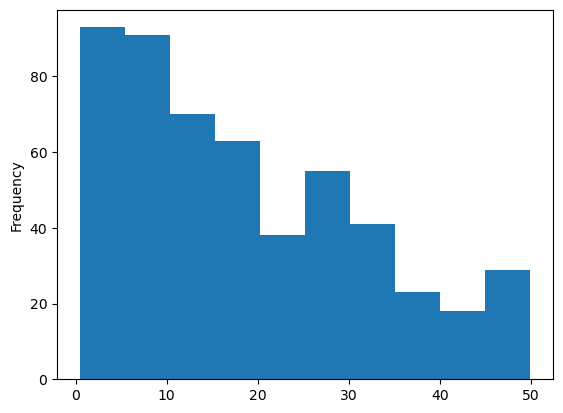

In [240]:
imputed_df_all.query("year_mun_id == '1909_Schinnen' & income_type == 'income_taxable' & is_imputed == True").sort_values('income_value').income_value.plot(kind='hist', bins=10)

In [243]:
imputed_df_all.query("year_mun_id == '1909_Schinnen' & income_type == 'income_taxable' & is_imputed == False").sort_values('income_value').groupby("income_value").size()#.plot(kind='bar')

income_value
50.0       72
100.0     350
150.0      94
200.0      68
250.0      66
300.0      40
350.0      46
400.0      48
500.0      46
600.0      56
700.0      32
800.0      24
900.0      10
1000.0     22
1100.0      4
1200.0      8
1300.0      2
1500.0      2
1600.0      4
1700.0      4
1800.0      2
1900.0      2
2000.0      4
2200.0      6
3000.0      2
3600.0      2
dtype: int64

In [95]:
cbs_large_long_prep.query("year_mun_id == '1899_Nijmegen'").T

,6173
year,1899
amco,11209
municipality,Nijmegen
bewoonde_huizen,6242.0
bewoonde_schepen,68.0
afzonderlijk_levenden,801.0
huisgezinnen,8208.0
bevolking,42756.0
beroepsbevolking,15114.0
bewoonde_huizen_schepen,6310.0


In [45]:
# cbs_large_long_prep.query("year_mun_id == '1899_Uden'").T

<Axes: ylabel='Density'>

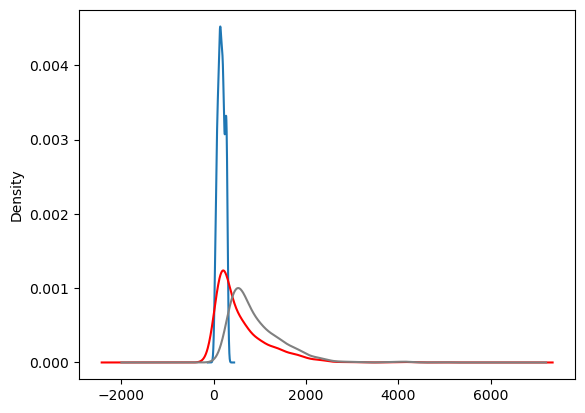

In [59]:
imputed_df_all.query("year_mun_id == '1899_Uden' & income_type == 'income_gross' & refpop_source == 'refpop_hh' & is_imputed == True").income_value.plot(kind='density')
imputed_df_all.query("year_mun_id == '1899_Uden' & income_type == 'income_gross' & refpop_source == 'refpop_hh'").income_value.plot(kind='density', color='red')
imputed_df_all.query("year_mun_id == '1899_Uden' & income_type == 'income_gross' & refpop_source == 'naive'").income_value.plot(kind='density', color='gray')


In [46]:
imputed_df_all.query("year_mun_id == '1899_Uden' & income_type == 'income_gross' & refpop_source == 'refpop_hh' & is_imputed == True").sort_values(by='income_value')#.income_value.describe()

,year_mun_id,cbs_year,tax_record_id,income_type,income_value,is_imputed,income_from_tax,tax_value,refpop_source,class_nr
123516,1899_Uden,1899,-1,income_gross,15.44,True,False,NaN,refpop_hh,NaN
123819,1899_Uden,1899,-1,income_gross,18.58,True,False,NaN,refpop_hh,NaN
123832,1899_Uden,1899,-1,income_gross,18.90,True,False,NaN,refpop_hh,NaN
123607,1899_Uden,1899,-1,income_gross,19.73,True,False,NaN,refpop_hh,NaN
123513,1899_Uden,1899,-1,income_gross,22.61,True,False,NaN,refpop_hh,NaN
...,...,...,...,...,...,...,...,...,...,...
123641,1899_Uden,1899,-1,income_gross,297.58,True,False,NaN,refpop_hh,NaN
123577,1899_Uden,1899,-1,income_gross,297.63,True,False,NaN,refpop_hh,NaN
123700,1899_Uden,1899,-1,income_gross,298.76,True,False,NaN,refpop_hh,NaN
123924,1899_Uden,1899,-1,income_gross,299.00,True,False,NaN,refpop_hh,NaN


In [47]:
imputed_df_all.query("year_mun_id == '1899_Uden' & income_type == 'income_gross' & refpop_source == 'refpop_hh'").income_value.describe()

count    1236.000000
mean      593.522427
std       580.373944
min        15.440000
25%       182.045000
50%       400.000000
75%       800.000000
max      4900.000000
Name: income_value, dtype: float64

In [50]:
tax_records.query("year_mun_id == '1917_Eindhoven'")[['income_raad', 'income_gross', 'income_taxable']].describe()

,income_raad,income_gross,income_taxable
count,2132.000000,2132.000000,2132.000000
mean,3448.016886,3845.950281,3448.016886
std,27706.853245,27706.983012,27706.853245
min,100.000000,500.000000,100.000000
25%,400.000000,800.000000,400.000000
50%,600.000000,1000.000000,600.000000
75%,1500.000000,1900.000000,1500.000000
max,836500.000000,836900.000000,836500.000000


<Axes: >

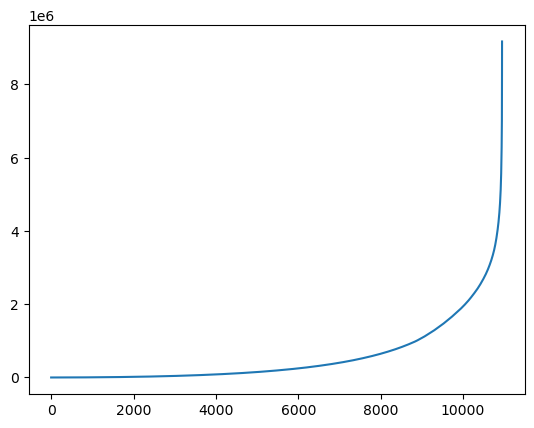

In [51]:
imputed_df_all.query("year_mun_id == '1917_Eindhoven' & income_type == 'income_gross' & refpop_source == 'refpop_catprop'")['income_value'].sort_values().reset_index(drop=True).cumsum().plot()

In [52]:
income_values_eindhoven = imputed_df_all.query("year_mun_id == '1917_Eindhoven' & income_type == 'income_gross' & refpop_source == 'refpop_catprop'")['income_value'].sort_values()
gini_coefficient(income_values_eindhoven)

0.874175784231566

In [53]:
print(*skiped_year_mun_ids, sep="\n")

('1899_Nijmegen', 'income_gross', '> Percentage filled for 1899_Nijmegen, income_gross is 0.021. Skipping imputation.')
('1899_Nijmegen', 'income_taxable', '> Percentage filled for 1899_Nijmegen, income_taxable is 0.021. Skipping imputation.')
('1899_Nijmegen', 'income_unspecified', '> Percentage filled for 1899_Nijmegen, income_unspecified is 0.021. Skipping imputation.')
('1909_Beek_(L.)', 'income_gross', '> Percentage filled for 1909_Beek_(L.), income_gross is 0.050. Skipping imputation.')
('1909_Brummen', 'income', '> Percentage filled for 1909_Brummen, income is 0.028. Skipping imputation.')
('1909_Leende', 'income_gross', '> Percentage filled for 1909_Leende, income_gross is 0.007. Skipping imputation.')


In [263]:
gini_summaries_df

,year_mun_id,income_type,count,mean,std,min,25%,50%,75%,max,income_type,year_mun_id,year,municipality
0,1859_Harlingen,tax,1000.0,0.668117,0.003697,0.655416,0.665661,0.668087,0.670531,0.679562,tax,1859_Harlingen,1859,Harlingen
1,1859_Harlingen,tax,1000.0,0.664211,0.003672,0.648596,0.661817,0.664211,0.666729,0.676274,tax,1859_Harlingen,1859,Harlingen
2,1870_Harlingen,tax,1000.0,0.674325,0.003507,0.663333,0.671906,0.674324,0.676797,0.684993,tax,1870_Harlingen,1870,Harlingen
3,1870_Harlingen,tax,1000.0,0.668776,0.003723,0.657341,0.666356,0.66854,0.671318,0.681948,tax,1870_Harlingen,1870,Harlingen
4,1889_Brouwershaven,tax,1000.0,0.536484,0.007101,0.514214,0.531837,0.53636,0.541013,0.555139,tax,1889_Brouwershaven,1889,Brouwershaven
5,1889_Brouwershaven,tax,1000.0,0.507843,0.006431,0.485728,0.503366,0.507742,0.51224,0.527892,tax,1889_Brouwershaven,1889,Brouwershaven
6,1889_Nijmegen,tax,1000.0,0.739332,0.001314,0.735305,0.73836,0.73932,0.740209,0.74298,tax,1889_Nijmegen,1889,Nijmegen
7,1889_Nijmegen,tax,1000.0,0.674788,0.00136,0.670635,0.673849,0.674754,0.67573,0.679696,tax,1889_Nijmegen,1889,Nijmegen
8,1899_Beesd,tax,1000.0,0.532478,0.004547,0.519309,0.529363,0.532524,0.535521,0.546391,tax,1899_Beesd,1899,Beesd
9,1899_Beesd,tax,1000.0,0.496277,0.003917,0.483922,0.493576,0.496292,0.498947,0.507926,tax,1899_Beesd,1899,Beesd


In [265]:
## save imputed_df_all to parquet
# convert class_nr to string
imputed_df_all.class_nr = imputed_df_all.class_nr.astype("string[pyarrow]")

# save to parquet
imputed_df_all.to_parquet("output/imputed_income_and_tax_from_income_2023_07_11_v2_1.parquet")

# save gini summaries to parquet
gini_summaries_df.to_parquet("output/gini_summaries_df_2023_07_11_v2_1.parquet")

## Dev

Impute incomes for all available income columns for each year_mun

In [774]:
# imputed_income_df = impute_income_values_df(tax_records_inc_ref)
# imputed_df.to_parquet("output/tax_records_latest_imputed_hh_income_v2_1.parquet", engine='pyarrow')

#### Impute tax

In [890]:
income_columns = ['tax', 'tax2', 'tax_raad', 'tax_raad2', 'tax2_raad']

# keep rows where income columns are not empty
tax_records_inc = tax_records[tax_records[income_columns].notnull().any(axis=1)].copy()

# add column income_impute to tax_records_inc, which consists of one of the columns from income_columns, in order of preference
tax_records_inc[['income_impute', 'income_impute_from']] = tax_records_inc.apply(lambda row: pd.Series(get_income_value(row, income_columns)), axis=1)

# bewaar de rijen waarvan de year_mun_id in cbs_sum_ref zit
# tax_records_inc_ref = tax_records_inc.query("year_mun_id.isin(@cbs_sum_ref.year_mun_id.unique())")
tax_records_inc_ref = tax_records_inc.query("year_mun_id.isin(@cbs_large.year_mun_id.unique())")

print(len(tax_records_inc_ref))

tax_records_inc_ref.head()

66857


,page_nr,place,volgnummer,wijk,house_nr_wijk,street,house_nr_street,title,firstnames,initials,...,deducations,income,month,notes_cleaning,cbs_year,cbscode,year_mun_id,amco_year,income_impute,income_impute_from
0,1,Eindhoven,1,<NA>,<NA>,Kerkstraat,9,Wed,<NA>,H.,...,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,11298_1920,9.6,tax
1,1,Eindhoven,2,<NA>,<NA>,Vrijstraat,47,<NA>,<NA>,A.,...,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,11298_1920,14.4,tax
2,1,Eindhoven,3,<NA>,<NA>,Vrijstraat,1,<NA>,Cath.,C.,...,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,11298_1920,19.2,tax
3,1,Eindhoven,4,<NA>,<NA>,Markt,14,<NA>,<NA>,H.,...,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,11298_1920,35.2,tax
4,1,Eindhoven,5,<NA>,<NA>,Prins Hendrikstraat,7a,<NA>,<NA>,J.,...,<NA>,<NA>,<NA>,<NA>,1920,GM0772,1917_Eindhoven,11298_1920,16.0,tax


In [891]:
tax_records_inc_ref_grouped = tax_records_inc_ref.groupby("year_mun_id")
grped_na = tax_records_inc_ref_grouped.apply(lambda grp: grp.notna().sum()).div(tax_records_inc_ref_grouped.size(), axis=0)
grped_na[income_columns] > 0.5

,tax,tax2,tax_raad,tax_raad2,tax2_raad
year_mun_id,,,,,
1849_Aardenburg,True,False,False,False,False
1858_Eindhoven,True,False,False,False,False
1858_Made_en_Drimmelen,True,False,True,False,False
1858_Riethoven,True,False,True,False,False
1859_Aardenburg,True,False,False,False,False
...,...,...,...,...,...
1920_Swalmen,True,False,True,False,False
1920_Uden,True,False,True,False,False
1920_Vaals,True,False,True,False,False


In [346]:
# imputed_income_df.to_parquet("output/tax_records_latest_imputed_income_v1_1.parquet", engine='pyarrow')
# imputed_df_tax_records.to_parquet("output/tax_records_latest_imputed_tax_v1.parquet", engine='pyarrow')

##### Tax to income pilot

In [415]:
# # find where tax schedule is present
# tax_records_with_schedule = tax_records_inc_ref.query("file_id.isin(@tax_schedule.file_id.unique())")

# # check sizes
# tax_records_with_schedule.groupby("year_mun_id").size()

In [416]:
# get tax schedule for each file in tax_records_with_schedule
tax_schedule_filtered = tax_schedule.query("year_mun_id.isin(@tax_records_long_income.year_mun_id.unique())")

# keep tax_schedule_filtered for each year_mun_id where at least three values in the max column are present
tax_schedule_filtered = tax_schedule_filtered.groupby("year_mun_id").filter(lambda grp: grp['max'].notna().sum() >= 3).copy()

# drop empty columns
tax_schedule_filtered.dropna(axis=1, how='all', inplace=True)
# Make tax column numeric
tax_schedule_filtered.tax = tax_schedule_filtered.tax.astype(float)

tax_schedule_filtered.year_mun_id.unique()

array(['1909_Uden', '1889_Brouwershaven', '1899_Nijmegen',
       '1889_Riethoven', '1911_Aardenburg', '1899_Riethoven',
       '1889_Maarheeze', '1899_Maarheeze', '1879_Maarheeze',
       '1899_Leende', '1889_Leende', '1909_Swalmen', '1909_Schinnen',
       '1909_Berg_en_Terblijt', '1899_Berg_en_Terblijt', '1889_Nijmegen',
       '1909_Beesd', '1899_Beesd', '1859_Harlingen', '1870_Harlingen',
       '1909_Brummen'], dtype=object)

In [417]:
# remove rows without a tax value
tax_schedule_filtered = tax_schedule_filtered.query("tax.notna()")

# add min_tax column, which is the minimum tax for each next class. The first class has no min_tax, so it is filled with 0. This asumes that
# a tax amount is more likely to be lower than the prescribed value for a certain income class than higher, due to deductions.
tax_schedule_filtered['min_tax'] = tax_schedule_filtered.groupby("year_mun_id")['tax'].shift(1) + 0.01

# fill first min_tax with 0
tax_schedule_filtered['min_tax'].fillna(0.0, inplace=True)

# add class number if missing for a group. These should just be row numbers for each year_mun_id
tax_schedule_filtered['class'] = tax_schedule_filtered.groupby("year_mun_id").cumcount() + 1
# fill class_nr with 'class' column
tax_schedule_filtered['class_nr'].fillna(tax_schedule_filtered['class'].astype(str), inplace=True)

# where the min column is empty, fill with the previous max value + 1
tax_schedule_filtered['min'].fillna(tax_schedule_filtered.groupby("year_mun_id")['max'].shift(1) + 1, inplace=True)
# fill first min with 0
tax_schedule_filtered['min'].fillna(0, inplace=True)



## FIX BROUWERSHAVEN TAX SCHEDULE ##
# replace max value for brouwershaven at class_nr 14 with 2700
filt = tax_schedule_filtered.eval("year_mun_id == '1889_Brouwershaven' & class_nr == '14'")
tax_schedule_filtered.loc[filt, "max"] = 2700

# fill min column in tax schedule for 1889_Brouwershaven. Min value is 300, then the rest is filled with the max values
# get max values
max_values = tax_schedule_filtered.query("year_mun_id == '1889_Brouwershaven'")['max'].tolist()
# add 300 to the beginning, so that the first value is 300, and remove the last value of max_values
min_values = [300] + max_values[:-1]

# fill min column
tax_schedule_filtered.loc[tax_schedule_filtered.year_mun_id == "1889_Brouwershaven", "min"] = min_values
tax_schedule_filtered.head()

In [192]:
# # candidates = [
# #     "1889_Brouwershaven",
# #     "1899_Beesd",
# #     "1859_Harlingen",
# #     "1870_Harlingen",
# #     ]

# candidates = tax_records_long_income.year_mun_id.unique().tolist()

# tax_schedule_filtered_candidates = tax_schedule_filtered.query("year_mun_id.isin(@candidates)").copy()
# # drop empty columns
# tax_schedule_filtered.dropna(axis=1, how='all', inplace=True)
# # Make tax column numeric
# tax_schedule_filtered_candidates.tax = tax_schedule_filtered_candidates.tax.astype(float)
# # filter tax_records 
# tax_records_filtered_candidates = tax_records_with_schedule.query("year_mun_id.isin(@candidates)").copy()


# # remove rows without a tax value
# tax_schedule_filtered_candidates = tax_schedule_filtered_candidates.query("tax.notna()")

# # add min_tax column, which is the minimum tax for each next class. The first class has no min_tax, so it is filled with 0. This asumes that
# # a tax amount is more likely to be lower than the prescribed value for a certain income class than higher, due to deductions.
# tax_schedule_filtered_candidates['min_tax'] = tax_schedule_filtered_candidates.groupby("year_mun_id")['tax'].shift(1) + 0.01

# # fill first min_tax with 0
# tax_schedule_filtered_candidates['min_tax'].fillna(0.0, inplace=True)

# # add class number if missing for a group. These should just be row numbers for each year_mun_id
# tax_schedule_filtered_candidates['class'] = tax_schedule_filtered_candidates.groupby("year_mun_id").cumcount() + 1
# # fill class_nr with 'class' column
# tax_schedule_filtered_candidates['class_nr'].fillna(tax_schedule_filtered_candidates['class'].astype(str), inplace=True)

# # where the min column is empty, fill with the previous max value + 1
# tax_schedule_filtered_candidates['min'].fillna(tax_schedule_filtered_candidates.groupby("year_mun_id")['max'].shift(1) + 1, inplace=True)
# # fill first min with 0
# tax_schedule_filtered_candidates['min'].fillna(0, inplace=True)



# ## FIX BROUWERSHAVEN TAX SCHEDULE ##
# # replace max value for brouwershaven at class_nr 14 with 2700
# filt = tax_schedule_filtered_candidates.eval("year_mun_id == '1889_Brouwershaven' & class_nr == '14'")
# tax_schedule_filtered_candidates.loc[filt, "max"] = 2700

# # fill min column in tax schedule for 1889_Brouwershaven. Min value is 300, then the rest is filled with the max values
# # get max values
# max_values = tax_schedule_filtered_candidates.query("year_mun_id == '1889_Brouwershaven'")['max'].tolist()
# # add 300 to the beginning, so that the first value is 300, and remove the last value of max_values
# min_values = [300] + max_values[:-1]

# # fill min column
# tax_schedule_filtered_candidates.loc[tax_schedule_filtered_candidates.year_mun_id == "1889_Brouwershaven", "min"] = min_values
# tax_schedule_filtered_candidates.head()


# brwrs = tax_records_with_schedule.query("year_mun_id == '1889_Brouwershaven'").copy()

# brwrs_tax_schedule = tax_schedule_filtered_candidates.query("year_mun_id == '1889_Brouwershaven'")
# brwrs_tax_rates = brwrs_tax_schedule.tax.astype(float).tolist()

In [418]:
## FIX BROUWERSHAVEN TAX SCHEDULE ##
# replace max value for brouwershaven at class_nr 14 with 2700
filt = tax_schedule_filtered.eval("year_mun_id == '1889_Brouwershaven' & class_nr == '14'")
tax_schedule_filtered.loc[filt, "max"] = 2700

# fill min column in tax schedule for 1889_Brouwershaven. Min value is 300, then the rest is filled with the max values
# get max values
max_values = tax_schedule_filtered.query("year_mun_id == '1889_Brouwershaven'")['max'].tolist()
# add 300 to the beginning, so that the first value is 300, and remove the last value of max_values
min_values = [300] + max_values[:-1]

# fill min column
tax_schedule_filtered.loc[tax_schedule_filtered.year_mun_id == "1889_Brouwershaven", "min"] = min_values
tax_schedule_filtered.head()

,class_nr,min,max,verhoudingscijfer,tax,grondslag voor berekening van de aanslag,year,file_name,place,municipality,amco,province,has_duplicate,file_id,sheet_name,pct,year_mun_id,min_tax,class
158,1,300,400,<NA>,2.58,<NA>,1889,Brouwershaven - 1889.xlsx,Brouwershaven,Brouwershaven,10030,Zeeland,False,13021319764,tax_schedule,<NA>,1889_Brouwershaven,0.00,1
159,2,400,500,<NA>,3.87,<NA>,1889,Brouwershaven - 1889.xlsx,Brouwershaven,Brouwershaven,10030,Zeeland,False,13021319764,tax_schedule,<NA>,1889_Brouwershaven,2.59,2
160,3,500,600,<NA>,6.45,<NA>,1889,Brouwershaven - 1889.xlsx,Brouwershaven,Brouwershaven,10030,Zeeland,False,13021319764,tax_schedule,<NA>,1889_Brouwershaven,3.88,3
161,4a,600,700,<NA>,7.74,<NA>,1889,Brouwershaven - 1889.xlsx,Brouwershaven,Brouwershaven,10030,Zeeland,False,13021319764,tax_schedule,<NA>,1889_Brouwershaven,6.46,4
162,4b,700,800,<NA>,10.32,<NA>,1889,Brouwershaven - 1889.xlsx,Brouwershaven,Brouwershaven,10030,Zeeland,False,13021319764,tax_schedule,<NA>,1889_Brouwershaven,7.75,5


#### Simulate

In [300]:
def get_class_table(df, tax_schedule, income_class_column="income_class"):

    class_table = df[income_class_column].value_counts().to_frame()
    
    class_table[['min', 'max']] = tax_schedule.groupby("class_nr")[['min', 'max']].mean()

    return class_table

# class_table = get_class_table(brwrs, brwrs_tax_schedule)
# class_table.head()

@numba.njit()
def random_class_incomes(min_values, max_values, counts):
    """Generate random income values for each class, based on the min and max values and the number of values to generate for each class"""
    
    # calculate total number of values to generate
    size = np.sum(counts)
    # create empty array
    all_class_incomes = np.empty(size)
    
    # generate random income values for each class, and add to all_class_incomes
    start = 0
    for i in range(len(min_values)):
        end = start + counts[i]
        all_class_incomes[start:end] = np.random.uniform(min_values[i], max_values[i], counts[i])
        start = end

    assert len(all_class_incomes) == counts.sum(), "Length of class_incomes should be equal to sum of income_class in class_table"

    return all_class_incomes


def random_class_incomes_wrapper(class_table):
    """Wrapper around random_class_incomes, to be able to input a pandas dataframe directly"""
    all_class_incomes = random_class_incomes(class_table['min'].to_numpy(), class_table['max'].to_numpy(), class_table['count'].to_numpy())
    return all_class_incomes


def find_class_and_income(row, tax_schedule):
    class_query = tax_schedule.query("@row.income_impute <= tax & @row.income_impute >= min_tax")

    if len(class_query) == 1:
        random_income =  np.random.uniform(class_query['min'].values[0], class_query['max'].values[0], 1)[0]
        return (class_query.class_nr.values[0], round(random_income, 2))
    
    elif len(class_query) > 1:
        print(f"More than one class found for {row.income_impute}")
    else:
        print(f"No class found for {row.income_impute} ({row.name})")

    return (None, None)


def find_class(df, tax_schedule, tax_value_column="tax"):

    tax_schedule = tax_schedule.sort_values(by='min_tax')

    bins = pd.IntervalIndex.from_tuples(tax_schedule[['min_tax', 'tax']].apply(tuple, axis=1), closed='both')
    labels = grp_tax_schedule['class_nr'].tolist()

    # Cut the data. You will have to cast it to float before using it.
    df['class_nr'] = pd.cut(df[tax_value_column], bins=bins).cat.codes
    df['class_nr'] = df['class_nr'].apply(lambda x: labels[x] if x != -1 else np.nan)

    return df['class_nr']


def confidence(x, confidence_level=.95, bootstrap_samples=0):
    "Calculate confidence interval for Gini coefficient"
    if not bootstrap_samples:
        lwr, upr = norm.interval(confidence_level, loc=x.mean(), scale=st.sem(x))

    else:
        # Perform bootstrap resampling and calculate Gini coefficient for each sample
        bootstrap_samples = st.bootstrap((x,), n_resamples=bootstrap_samples, statistic=np.mean, method='percentile', confidence_level=confidence_level)
        # Get conficence interval
        lwr, upr = bootstrap_samples.confidence_interval
        
    return (lwr, upr)

##### do simulation

In [211]:
tax_records_long_income

,year_mun_id,cbs_year,tax_record_id,income_type,income_value,is_imputed,income_from_tax,tax_value,refpop_source
0,1917_Eindhoven,1920,0,income_gross,1000.000,False,False,NaN,naive
1,1917_Eindhoven,1920,0,income_raad,600.000,False,False,NaN,naive
2,1917_Eindhoven,1920,0,income_taxable,600.000,False,False,NaN,naive
3,1917_Eindhoven,1920,0,tax,9.600,False,True,9.600,naive
4,1917_Eindhoven,1920,0,tax2,1.200,False,True,1.200,naive
...,...,...,...,...,...,...,...,...,...
165417,1909_Brummen,1909,70414,tax,11.865,False,True,11.865,naive
165418,1909_Brummen,1909,70415,income,50.000,False,False,NaN,naive
165419,1909_Brummen,1909,70415,tax,0.750,False,True,0.750,naive
165420,1909_Brummen,1909,70416,income,16000.000,False,False,NaN,naive


In [405]:
tax_records_long_income_grp = tax_records_long_income.groupby(["year_mun_id", "income_type"])

grp_keys = list(tax_records_long_income_grp.groups.keys())
grp_keys = [i for i in grp_keys if i[0] in tax_schedule_filtered.year_mun_id.unique()]

grp_key = grp_keys[0]

year_mun_id = grp_key[0]

grp = tax_records_long_income_grp.get_group(grp_key).copy()
grp.head()

,year_mun_id,cbs_year,tax_record_id,income_type,income_value,is_imputed,income_from_tax,tax_value,refpop_source
161672,1859_Harlingen,1859,67979,tax,9.0,False,True,9.0,naive
161673,1859_Harlingen,1859,67980,tax,6.0,False,True,6.0,naive
161674,1859_Harlingen,1859,67981,tax,9.0,False,True,9.0,naive
161675,1859_Harlingen,1859,67982,tax,6.0,False,True,6.0,naive
161676,1859_Harlingen,1859,67983,tax,14.0,False,True,14.0,naive


In [406]:
grp_tax_schedule = tax_schedule_filtered.query("year_mun_id == @year_mun_id")

if len(grp_tax_schedule) == 0:
    print(f"No tax schedule found for {year_mun_id}")

# assign class nrs
grp['class_nr'] = find_class(grp, grp_tax_schedule, "tax_value")
# get class table
class_table = get_class_table(grp, grp_tax_schedule, 'class_nr')


# generate random incomes
simulated_incomes = random_class_incomes_wrapper(class_table)


# # sort grp by class_nr
# grp.sort_values(by='class_nr', inplace=True)

# # add simulated incomes (where class_nr is not nan)
# grp.loc[grp.class_nr.notna(), ['simulated_income']] = simulated_incomes
# # set simulated_income to income_value where class_nr is nan
# grp.loc[grp.class_nr.isna(), ['simulated_income']] = None

# # sort grp again by index
# grp.sort_index(inplace=True)

In [407]:
refpops = cbs_large_long_grp.get_group(year_mun_id)
refpops

,year_mun_id,refpop_source,refpop
12,1859_Harlingen,refpop_catprop,2347
13,1859_Harlingen,refpop_hh,2275


In [379]:
n_missing = refpops.refpop.iloc[1] - len(grp)
n_missing

1733

In [439]:
def get_class_table(df, tax_schedule, income_class_column="income_class"):
    # count number of values in each class
    class_table = df[income_class_column].value_counts().to_frame()
    # add min and max values for each class
    class_table[['min', 'max']] = tax_schedule.groupby("class_nr")[['min', 'max']].mean()
    return class_table


def find_class(df, tax_schedule, tax_value_column="tax"):

    tax_schedule = tax_schedule.sort_values(by='min_tax')

    bins = pd.IntervalIndex.from_tuples(tax_schedule[['min_tax', 'tax']].apply(tuple, axis=1), closed='both')
    labels = grp_tax_schedule['class_nr'].tolist()

    # Cut the data. You will have to cast it to float before using it.
    df['class_nr'] = pd.cut(df[tax_value_column], bins=bins).cat.codes
    df['class_nr'] = df['class_nr'].apply(lambda x: labels[x] if x != -1 else np.nan)

    return df['class_nr']


def simulate_and_impute_incomes(grp, year_mun_id, n_missing, tax_schedule, n_iterations=1000, n_pools=6):

    # assign class nrs
    grp['class_nr'] = find_class(grp, tax_schedule, "tax_value")
    # get class table
    class_table = get_class_table(grp, tax_schedule, 'class_nr')

    # Here, `args` represents variables you need for `impute_and_calc_gini()`
    # like `n_missing` and `class_table`, you need to replace it with your actual variables.
    args = [(i, n_missing, class_table) for i in range(n_iterations)]
    # Create a pool of workers, and map `impute_and_calc_gini()` to the pool
    with mp.Pool(n_pools) as pool:
        results = pool.starmap(impute_and_calc_gini, args)
    # `results` is a list of tuples, where each tuple is the result of `impute_and_calc_gini()`
    ginis, simulated_incomes_list, imputed_results = zip(*results)

    # conver ginist to series
    ginis = pd.Series(ginis)

    # find index of gini closest to the mean
    idx = (np.abs(ginis - ginis.mean())).idxmin()
    # get simulated incomes with idx
    simulated_incomes_best = simulated_incomes_list[idx]

    # sort grp by class_nr
    grp.sort_values(by='class_nr', inplace=True)

    # add simulated incomes (where class_nr is not nan)
    grp.loc[grp.class_nr.notna(), ['income_value']] = simulated_incomes_best
    # set simulated_income to income_value where class_nr is nan
    grp.loc[grp.class_nr.isna(), ['income_value']] = None

    # sort grp again by index
    grp.sort_index(inplace=True)

    # get only imputed values
    imputed_values = imputed_results[idx][grp.shape[0]:]

    # create gini summary
    gini_summary = ginis.describe()
    gini_summary.name = year_mun_id

    return (grp, imputed_values, gini_summary)

In [441]:
# get tax schedule for current year_mun_id
grp_tax_schedule = tax_schedule_filtered.query("year_mun_id == @year_mun_id")

if len(tax_schedule) == 0:
    print(f"No tax schedule found for {year_mun_id}")
    
grp_imp, imputed_values, gini_summary = simulate_and_impute_incomes(grp, year_mun_id, n_missing, tax_schedule=grp_tax_schedule, n_iterations=1000, n_pools=6)

In [428]:
gini_summary.name = year_mun_id

In [409]:
# find index of gini closest to the mean
idx = (np.abs(ginis - ginis.mean())).idxmin()
idx, ginis[idx], gini_coefficient(imputed_results[idx])

(62, 0.6389155287301551, 0.6389155287301551)

In [410]:
simulated_incomes_best = simulated_incomes_list[idx]

# sort grp by class_nr
grp.sort_values(by='class_nr', inplace=True)

# add simulated incomes (where class_nr is not nan)
grp.loc[grp.class_nr.notna(), ['income_value']] = simulated_incomes_best
# set simulated_income to income_value where class_nr is nan
grp.loc[grp.class_nr.isna(), ['income_value']] = None

# sort grp again by index
grp.sort_index(inplace=True)

In [411]:
imputed_results_repr[grp.shape[0]:][0], imputed_results_repr[grp.shape[0]]

(214.67556326518127, 214.67556326518127)

In [412]:
# Create dataframe with the original grp, and the imputed values. First create a dataframe from the imputed values,
# then concat with the original grp
imputed_values = imputed_results[idx][grp.shape[0]:]
# create imputed_df
imputed_df = pd.DataFrame({
    "year_mun_id" : year_mun_id, 
    "cbs_year" : grp.cbs_year.iloc[0], 
    "tax_record_id" : -1,
    "refpop_source" : refpop_row["refpop_source"],
    "income_type" : income_type, 
    "income_value" : imputed_values, 
    'is_imputed' : True,
    "income_from_tax" : grp.income_from_tax.iloc[0],
    "class_nr" : -1,
    })

# concat grp with imputed_df        
imputed_df = pd.concat([grp, imputed_df], ignore_index=True)
# set refpop_source to the refpop_source value (the grp df has 'naive' as refpop_source)
imputed_df["refpop_source"] = refpop_row["refpop_source"]

In [414]:
imputed_df

,year_mun_id,cbs_year,tax_record_id,income_type,income_value,is_imputed,income_from_tax,tax_value,refpop_source,class_nr
0,1859_Harlingen,1859,67979,tax,704.227836,False,True,9.0,refpop_hh,2
1,1859_Harlingen,1859,67980,tax,562.425993,False,True,6.0,refpop_hh,1
2,1859_Harlingen,1859,67981,tax,1655.454027,False,True,9.0,refpop_hh,2
3,1859_Harlingen,1859,67982,tax,629.049810,False,True,6.0,refpop_hh,1
4,1859_Harlingen,1859,67983,tax,1517.136891,False,True,14.0,refpop_hh,4
...,...,...,...,...,...,...,...,...,...,...
2270,1859_Harlingen,1859,-1,tax_raad,171.775201,True,True,NaN,refpop_hh,-1
2271,1859_Harlingen,1859,-1,tax_raad,110.624421,True,True,NaN,refpop_hh,-1
2272,1859_Harlingen,1859,-1,tax_raad,213.496964,True,True,NaN,refpop_hh,-1
2273,1859_Harlingen,1859,-1,tax_raad,1089.404628,True,True,NaN,refpop_hh,-1


In [944]:
year_mun_id_candidates = tax_schedule_filtered_candidates.year_mun_id.unique()

# get groups where tax column is not empty
year_mun_id_candidates = tax_schedule_filtered_candidates.groupby("year_mun_id").apply(lambda grp: grp['tax'].notna().sum() > 1)
year_mun_id_candidates = year_mun_id_candidates[year_mun_id_candidates].index.tolist()


year_mun_id = "1889_Brouwershaven"
year_mun_id = year_mun_id_candidates[4]
print(year_mun_id)

# get tax_records for this municipality
df = tax_records_filtered_candidates.query("year_mun_id == @year_mun_id").copy()
# get tax_schedule for this municipality
tax_schedule_df = tax_schedule_filtered_candidates.query("year_mun_id == @year_mun_id")



# find class and assing initial income
df[['income_class', 'income_impute_random']] = df.apply(lambda x : find_class_and_income(x, tax_schedule_df), axis=1, result_type='expand').values

# set income column used for imputation
income_column = "income_impute_random"

# get stats for this municipality
# stats_muni = cbs_sum_ref.query("year_mun_id == @year_mun_id")
stats_muni = cbs_large.query("year_mun_id == @year_mun_id")

# get number of refpop
# n_refpop = stats_muni.refpop_prop.values[0]
n_refpop = stats_muni['refpop'].values[0]

# get number of missing
n_missing = n_refpop - len(df)
print(f"missing: {n_missing}. {n_refpop = }, n_records: {len(df)}")
# get class table with min and max values for each class, and number of observations in each class
class_table = get_class_table(df, tax_schedule_df)

# # get values to impute
# y_to_impute = random_class_incomes(class_table)

# For comparison, impute tax values and calculate gini
imputed_tax = sample_from_lognormal(df['income_impute'], n_missing)
gini_tax = gini_coefficient(imputed_tax)
print("Gini imputed tax:", gini_tax)

ginis = []
for i in tqdm.tqdm(range(1000)):
    # get values to impute
    y_to_impute = random_class_incomes(class_table)
    # impute values
    imputed = sample_from_lognormal(y_to_impute, n_missing)
    # calculate gini
    gini = gini_coefficient(imputed)
    # add gini to list
    ginis.append(gini)
    
# create pandas series from all ginis
ginis = pd.Series(ginis)

ginis_stats = ginis.describe()
ginis_stats['ci_lwr'], ginis_stats['ci_upr'] = confidence(ginis, .95, bootstrap_samples=1000)
ginis_stats

1899_Beesd
missing: 360. n_refpop = 679, n_records: 319
Gini imputed tax: 0.794764566210681


100%|██████████| 1000/1000 [00:05<00:00, 199.80it/s]


count     1000.000000
mean         0.477202
std          0.008408
min          0.450160
25%          0.471540
50%          0.476990
75%          0.482285
max          0.507238
ci_lwr       0.476702
ci_upr       0.477764
dtype: float64

In [978]:
class_table.sort_values

,count,min,max
income_class,,,
1,55,325,300
11,25,575,550
5,23,425,400
8,21,500,475
9,21,525,500
6,19,450,425
14,19,600,625
7,16,475,450
2,15,350,325


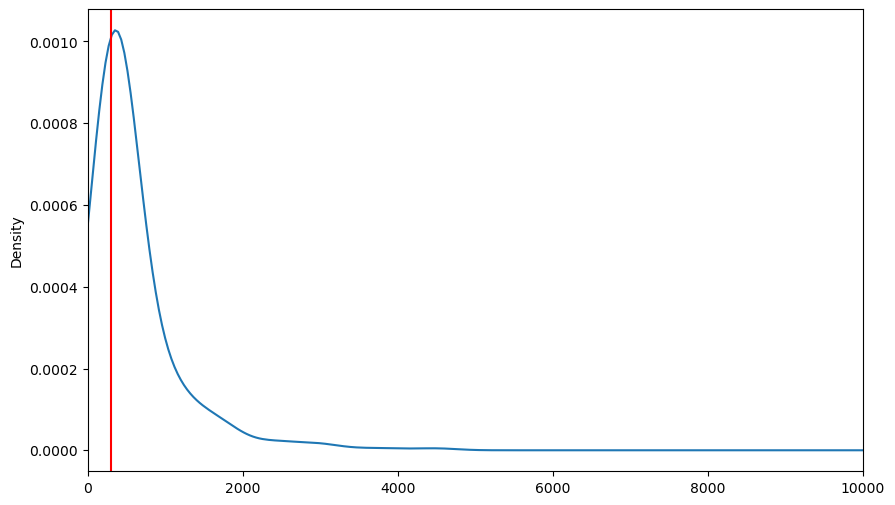

In [988]:
plt.figure(figsize=(10, 6))
pd.Series(imputed).plot(kind='density')
# set x lim
plt.xlim(0, 10000)
# add line at 300
plt.axvline(300, color='red')

In [ ]:
imputed_tax_series = pd.Series(imputed_tax)
imputed_tax_series

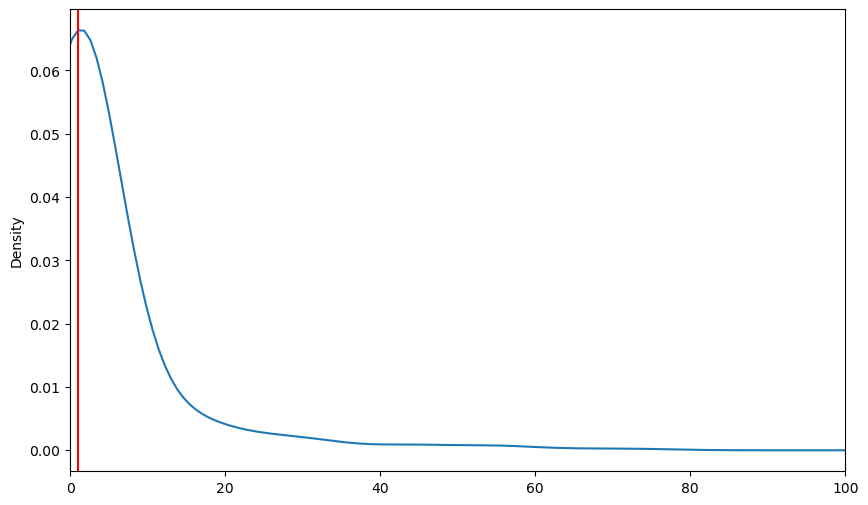

In [989]:
plt.figure(figsize=(10, 6))
pd.Series(imputed_tax).plot(kind='density')
# set x lim
plt.xlim(0, 100)
plt.axvline(1, color='red')

In [531]:
gini_coefficient(df["income_impute"])

0.5497132320771008

In [533]:
y_to_impute = df['income_impute'].values
imputed_tax = sample_from_lognormal(y_to_impute, n_missing)
gini_tax = gini_coefficient(imputed_tax)
print(gini_tax)

0.7196738424253606


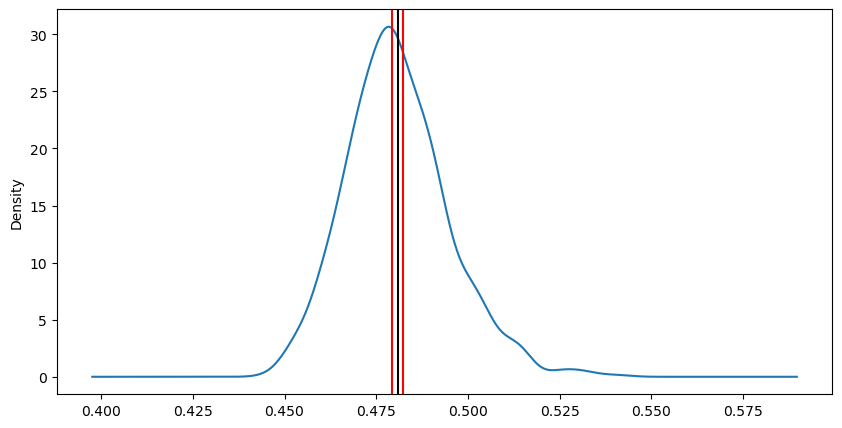

In [449]:
# plot ginis with confidence interval
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
ginis.plot(kind='density')
plt.axvline(ginis_stats['ci_lwr'], color='red')
plt.axvline(ginis_stats['ci_upr'], color='red')
plt.axvline(ginis_stats['mean'], color='black')
plt.show()

In [272]:
# ginis_random_simulated_incomes = ginis.copy()
# ginis_static_random_incomes = ginis.copy()

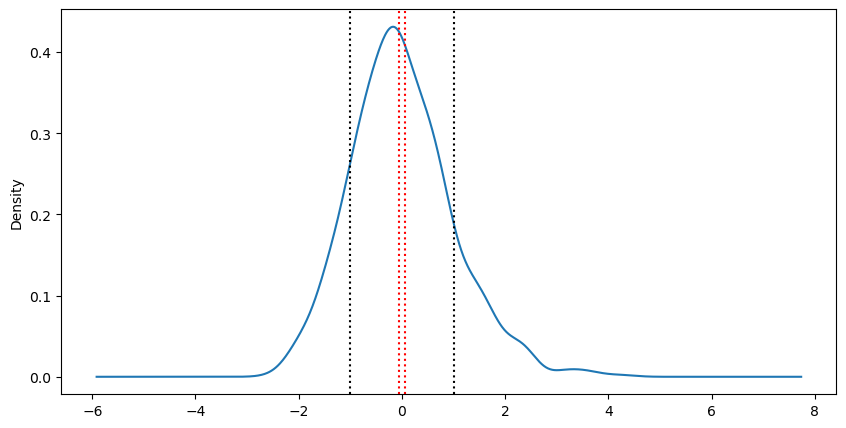

In [458]:
# plot gini's with lines for one and two standard deviations
import matplotlib.pyplot as plt
# standardize ginis
ginis_std = (ginis - ginis.mean()) / ginis.std()
# plot
plt.figure(figsize=(10, 5))
# plt.hist(ginis_std, bins=50)
ginis_std.plot(kind='density')
plt.axvline(x=1, color='black', linestyle='dotted')
plt.axvline(x=-1, color='black', linestyle='dotted')

lwr, upr = confidence(ginis_std, .95, 1000)
plt.axvline(x=lwr, color='red', linestyle='dotted')
plt.axvline(x=upr, color='red', linestyle='dotted')

plt.show()